<a href="https://colab.research.google.com/github/ebonhart99/Predicting-Loan-Default/blob/main/Eric_Mayo_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [ ]:
!pip install autogluon.tabular dalex

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -- model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

# -- pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split

import dalex as dx # for explanations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pickle
from scipy.stats import randint
from sklearn.inspection import permutation_importance

# Import Data

In [ ]:
loan = pd.read_csv('/content/loan_train.csv')
loan.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv       term  \
0  1077501.0  1296599.0     5000.0       5000.0           4975.0  36 months   
1  1077430.0  1314167.0     2500.0       2500.0           2500.0  60 months   
2  1076863.0  1277178.0    10000.0      10000.0          10000.0  36 months   
3  1069639.0  1304742.0     7000.0       7000.0           7000.0  60 months   
4  1072053.0  1288686.0     3000.0       3000.0           3000.0  36 months   

  int_rate  installment grade sub_grade  ... next_pymnt_d last_credit_pull_d  \
0   10.65%       162.87     B        B2  ...          NaN           Sep-2016   
1   15.27%        59.83     C        C4  ...          NaN           Sep-2016   
2   13.49%       339.31     C        C1  ...          NaN           Apr-2016   
3   15.96%       170.08     C        C5  ...          NaN           Sep-2016   
4   18.64%       109.43     E        E1  ...          NaN           Dec-2014   

  collections_12_mths_ex_med  policy_code application_type acc_now_delinq  \
0                        0.0          1.0       INDIVIDUAL            0.0   
1                        0.0          1.0       INDIVIDUAL            0.0   
2                        0.0          1.0       INDIVIDUAL            0.0   
3                        0.0          1.0       INDIVIDUAL            0.0   
4                        0.0          1.0       INDIVIDUAL            0.0   

  chargeoff_within_12_mths delinq_amnt pub_rec_bankruptcies tax_liens  
0                      0.0         0.0                  0.0       0.0  
1                      0.0         0.0                  0.0       0.0  
2                      0.0         0.0                  0.0       0.0  
3                      0.0         0.0                  0.0       0.0  
4                      0.0         0.0                  0.0       0.0  

[5 rows x 52 columns]

In [ ]:
loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

# Exploratory Analysis

Looking at nulls is always a must. Here I see that there are some nulls, but I will leave these for now. They will be dealt with during the preprocessing stage of the pipelines.

In [ ]:
loan.isnull().sum()

id                                3
member_id                         3
loan_amnt                         3
funded_amnt                       3
funded_amnt_inv                   3
term                              3
int_rate                          3
installment                       3
grade                             3
sub_grade                         3
emp_title                      1822
emp_length                      762
home_ownership                    3
annual_inc                        4
verification_status               3
issue_d                           3
loan_status                       0
pymnt_plan                        3
url                               3
desc                           9433
purpose                           3
title                            14
zip_code                          3
addr_state                        3
dti                               3
delinq_2yrs                      23
earliest_cr_line                 23
fico_range_low              

## Clean Up Columns

Just making sure that everything is in order and uniform.

In [ ]:
loan.columns = ( loan.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('?', '')
    .str.replace('\'', '') # notice the backslash \ this is an escape character
)
print(loan.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')


## Basic Decision

Here I want to get a good luck at the data. Mainly, which columns have only one value in the entire column? We do not want this data messing with the final metric results, so I will drop these from my set before moving onto the preprocessing stage.

In [ ]:
def loan_profile(loan, target):

    loan = loan.copy()

    numeric_features = [ c for c in loan.select_dtypes(include = np.number).columns ]

    categorical_features = [ c for c in loan.select_dtypes(include = object).columns ]

    rowcnt = len(loan)
    loan_s1  = loan.agg(['count', 'nunique','mean','min','max']).transpose().reset_index().rename(columns={"index":"feature_name"}).round(4)
    loan_s1['count'] = loan_s1['count'].astype('int64')
    loan_s1['nunique'] = loan_s1['nunique'].astype('int64')
    loan_s1["null"] = (rowcnt - loan_s1["count"]).astype('int64')
    loan_s1["not_null"] = rowcnt - loan_s1["null"]
    loan_s1["null_pct"] = loan_s1["null"] / rowcnt
    loan_s1["nunique_pct"] = loan_s1['nunique'] / rowcnt
    dt = pd.DataFrame(loan.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    loan_stats = pd.merge(dt, loan_s1, on='feature_name', how='inner')

    loan_stats = loan_stats.sort_values("dtype").reset_index(drop=True)
    # -- part 2
    loan_stats['feature_type'] = "UNKOWN"
    loan_stats.loc[loan_stats["dtype"] == object, 'feature_type'] = "CATEGORY"
    loan_stats.loc[(loan_stats["dtype"] == "int64") | (loan_stats["dtype"] == "float64"), 'feature_type'] = "NUMERIC"
    # loan_stats.loc[loan_stats["dtype"] == "float64", 'feature_type'] = "NUMERIC"
    loan_stats.loc[loan_stats["feature_name"] == target, 'feature_type'] = "TARGET"


    # -- part 3
    loan_stats['feature_warning'] = "NO WARNING"
    loan_stats.loc[loan_stats["nunique_pct"] > 0.7,'feature_warning' ] = "EXCLUDE, GT 70% UNIQUE"
    loan_stats.loc[(loan_stats["null_pct"] > 0.2) & (loan_stats["null_pct"] <= 0.5), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    loan_stats.loc[loan_stats["null_pct"] > 0.5,'feature_warning' ] = "EXCLUDE, GT 50% MISSING"
    loan_stats.loc[((loan_stats['dtype'] == "int64" ) | (loan_stats['dtype'] == "float64" ) ) & (loan_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"

    return loan_stats

loan_profile(loan, "loan_status")

feature_name    dtype  count  nunique           mean  \
0                           id  float64  29774    29774  663006.184523   
1               fico_range_low  float64  29774       43     713.053167   
2              fico_range_high  float64  29774       43     717.053167   
3               inq_last_6mths  float64  29754       27        1.08409   
4       mths_since_last_delinq  float64  10870       90      34.715823   
5       mths_since_last_record  float64   2569      107       59.22538   
6                     open_acc  float64  29754       44       9.339013   
7                      pub_rec  float64  29754        6       0.058547   
8                    revol_bal  float64  29774    18399   14310.000638   
9         pub_rec_bankruptcies  float64  28811        3        0.04533   
10                   total_acc  float64  29754       78      22.082779   
11               out_prncp_inv  float64  29774      384      11.764315   
12          total_rec_late_fee  float64  29774     1604       1.504783   
13             last_pymnt_amnt  float64  29774    26903     2615.40548   
14  collections_12_mths_ex_med  float64  29673        1            0.0   
15                 policy_code  float64  29774        1            1.0   
16              acc_now_delinq  float64  29754        2       0.000134   
17    chargeoff_within_12_mths  float64  29673        1            0.0   
18                 delinq_amnt  float64  29754        3       0.204342   
19                   out_prncp  float64  29774      383      11.796288   
20                         dti  float64  29774     2846      13.384026   
21                 delinq_2yrs  float64  29754       11       0.155038   
22                   tax_liens  float64  29698        2       0.000034   
23                   member_id  float64  29774    29774  823568.145966   
24                   loan_amnt  float64  29774      827   11109.434406   
25                 funded_amnt  float64  29774      981   10843.637066   
26             funded_amnt_inv  float64  29774     6862   10149.655315   
27                  annual_inc  float64  29773     4286   69201.232288   
28                 installment  float64  29774    13255     323.808152   
29            application_type   object  29774        1            NaN   
30                        term   object  29774        2            NaN   
31          last_credit_pull_d   object  29772      109            NaN   
32                next_pymnt_d   object   2352       96            NaN   
33                    int_rate   object  29774      390            NaN   
34                last_pymnt_d   object  29710      106            NaN   
35                       grade   object  29774        7            NaN   
36                   sub_grade   object  29774       35            NaN   
37                    zip_code   object  29774      819            NaN   
38                  revol_util   object  29710     1094            NaN   
39                  emp_length   object  29015       11            NaN   
40              home_ownership   object  29774        5            NaN   
41         verification_status   object  29774        3            NaN   
42                     issue_d   object  29774       55            NaN   
43                 loan_status   object  29777        2            NaN   
44                  pymnt_plan   object  29774        2            NaN   
45                         url   object  29774    29774            NaN   
46            earliest_cr_line   object  29754      516            NaN   
47                        desc   object  20344    20309            NaN   
48                     purpose   object  29774       14            NaN   
49                  addr_state   object  29774       50            NaN   
50                       title   object  29763    15199            NaN   
51                   emp_title   object  27955    22141            NaN   

        min        max   null  not_null  null_pct  nunique_pct feature_type  \
0   54734.0  107

In [ ]:
loan['fico_range_high'].max()

829.0

Based off of the results, I want to make sure the models do not include: collections_12_mths_ex_med, pub_rec_bankruptcies, policy_code, chargeoff_within_12_mths, and application_type

In [ ]:
loan.loan_status.value_counts(normalize=True)

loan_status
current    0.849649
default    0.150351
Name: proportion, dtype: float64

## Features

Here are some features that'll be used.

In [ ]:
loan['last_pmnt_d'] = pd.to_datetime(loan['last_pymnt_d'], format='%b-%Y')
loan['issue_d'] = pd.to_datetime(loan['issue_d'], format='%b-%Y')

loan['days_between'] = (loan['last_pmnt_d'] - loan['issue_d']).dt.days

In [ ]:
target = 'loan_status'
numeric_features = loan.select_dtypes(include=['int64', 'float64']).columns
#print(numeric_features)
numeric_features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee',
       'last_pymnt_amnt', 'days_between']
print(numeric_features)
categorical_features = loan.select_dtypes(include=['object']).columns
#print(categorical_features)
categorical_features = ['grade', 'sub_grade','home_ownership', 'verification_status']
print(categorical_features)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_amnt', 'days_between']
['grade', 'sub_grade', 'home_ownership', 'verification_status']


## Numeric Exploration

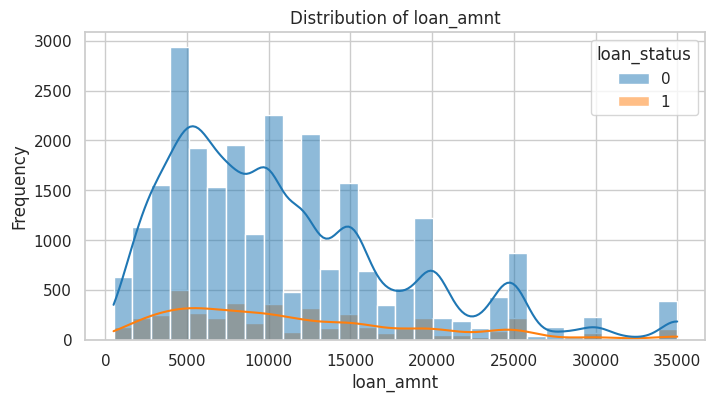

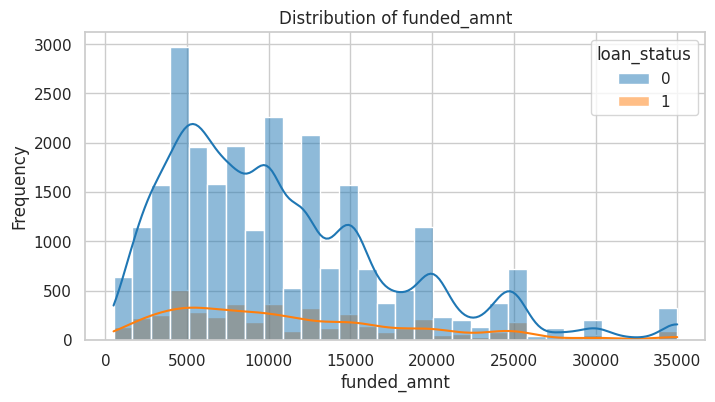

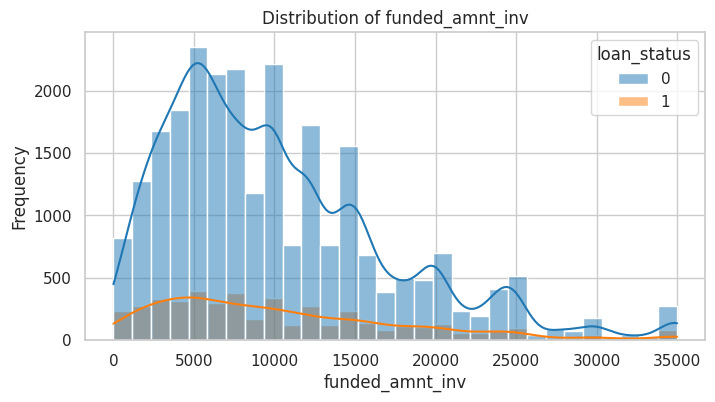

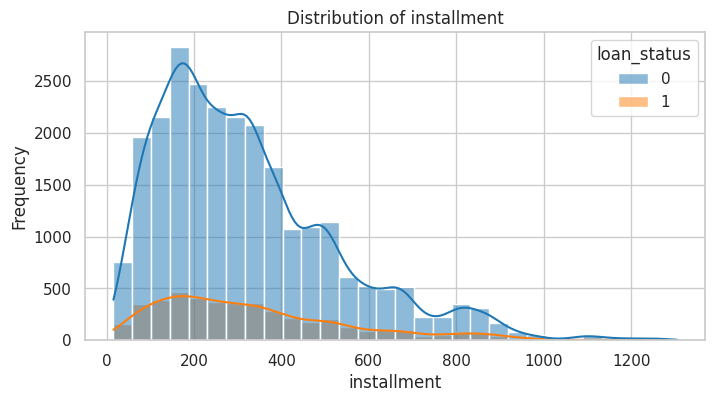

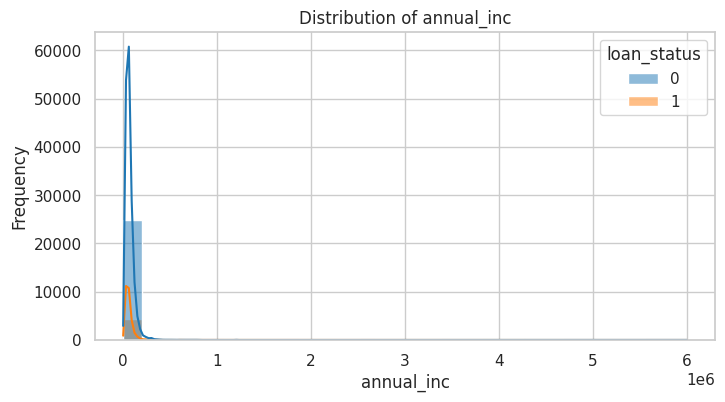

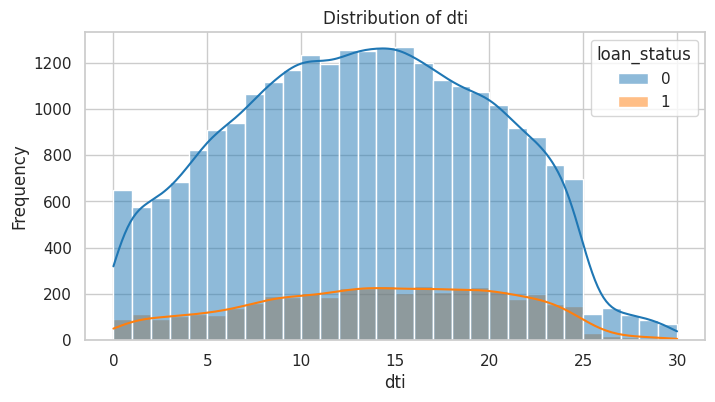

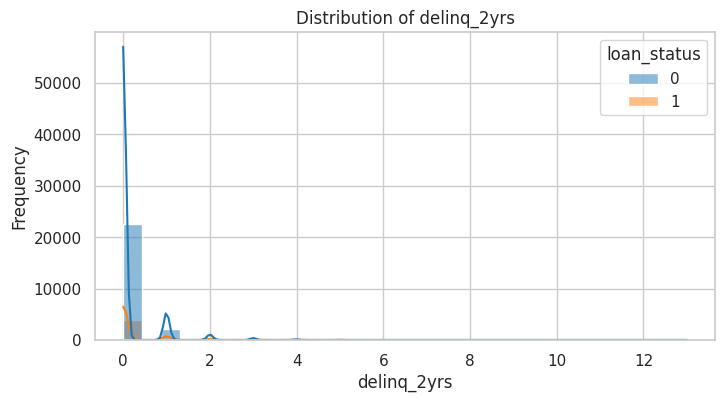

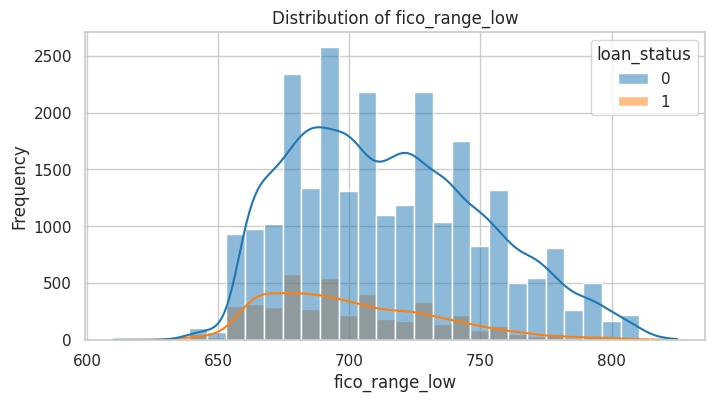

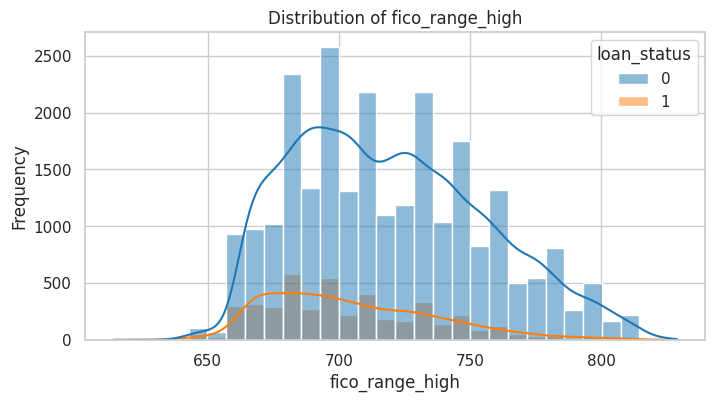

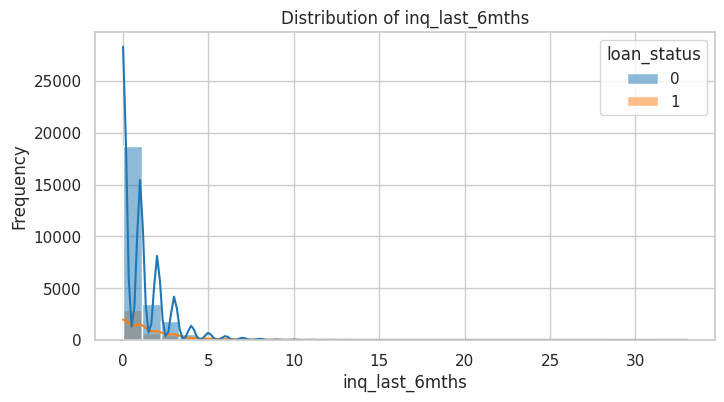

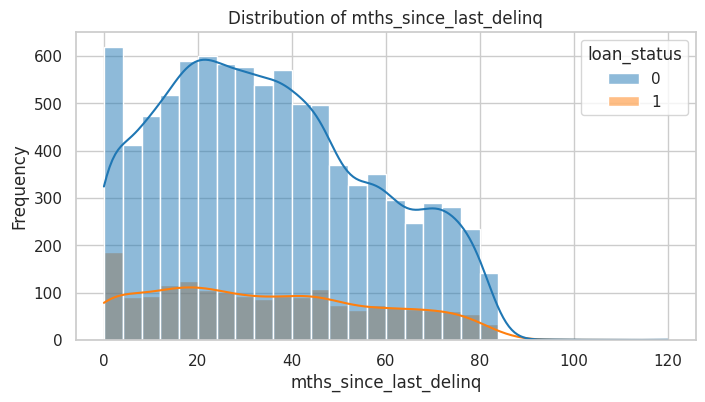

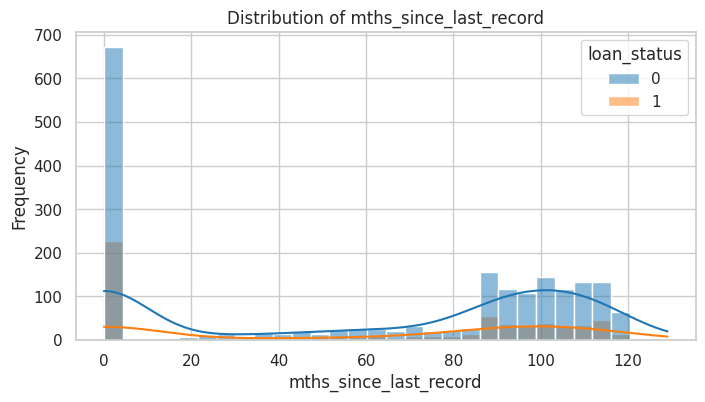

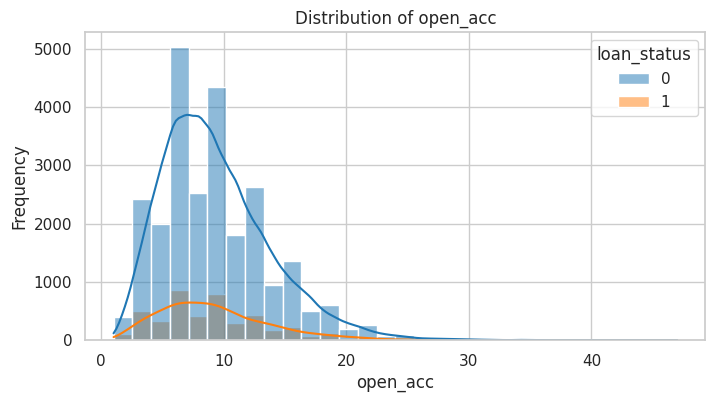

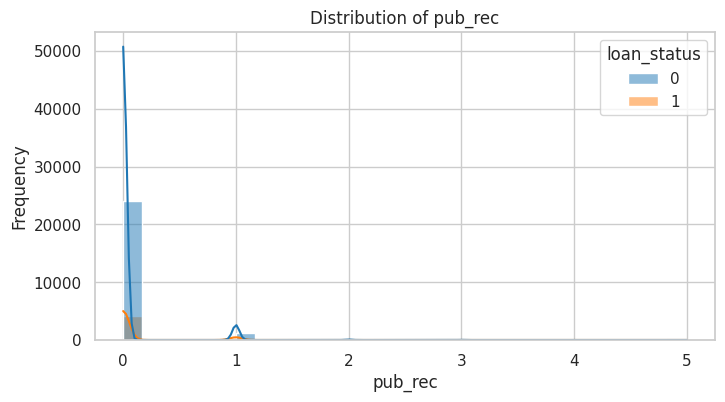

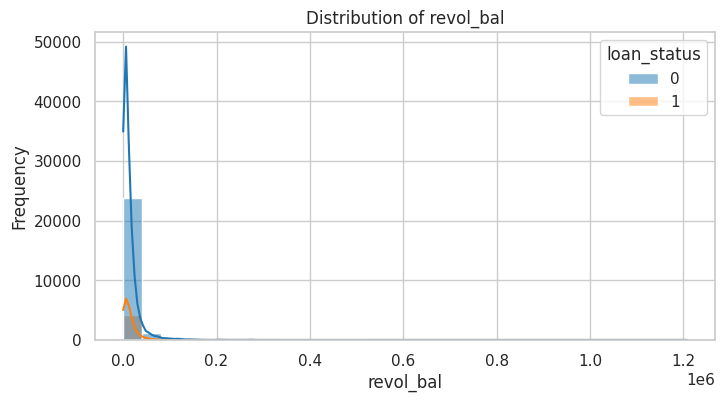

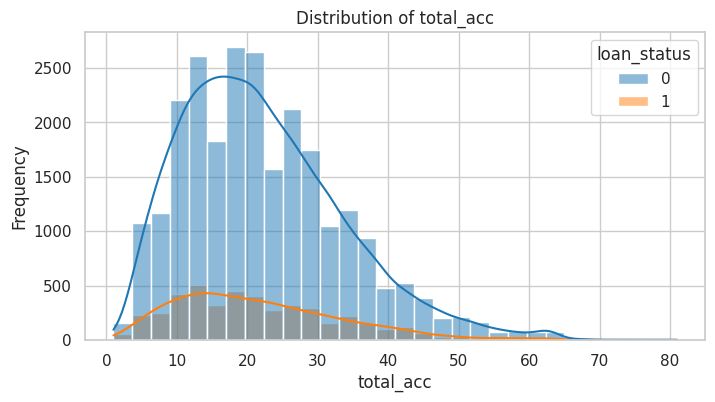

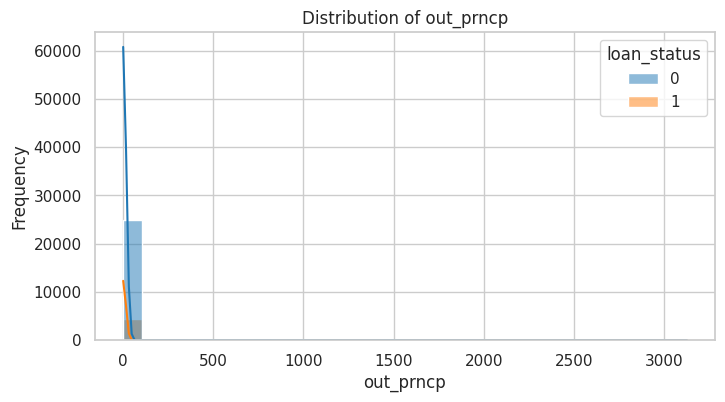

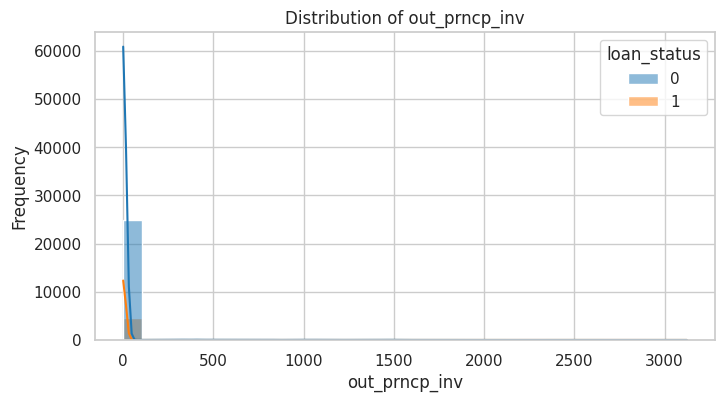

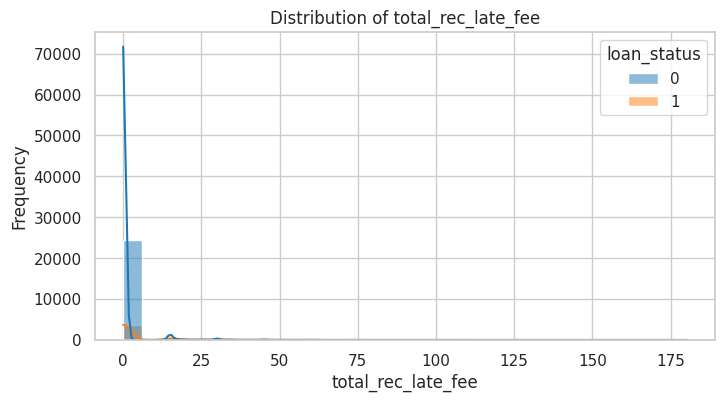

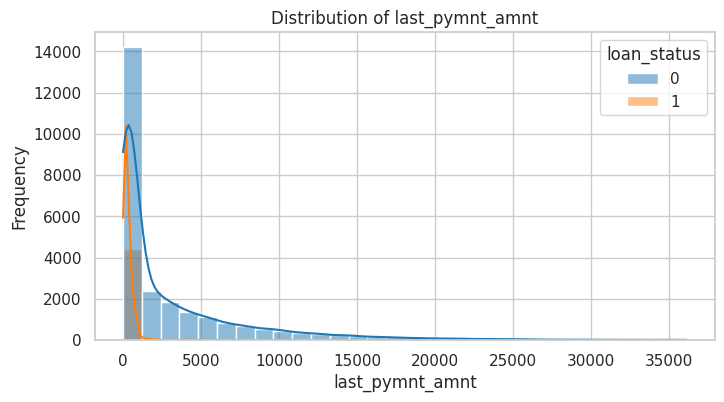

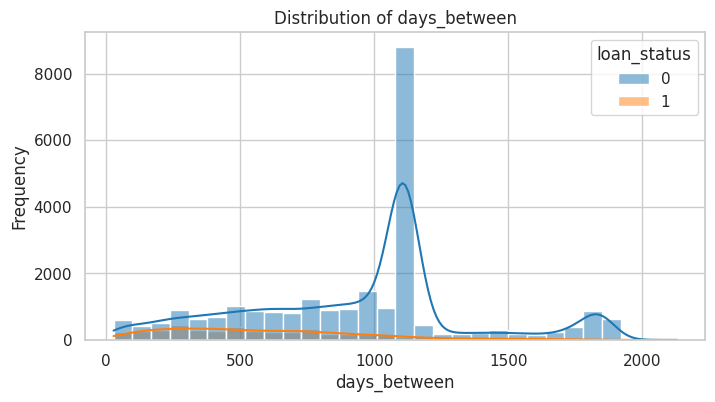

In [ ]:
# Setting the aesthetic style of the plots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data= loan, x=feature, hue="loan_status", kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

Looking at the boxplots, I can see that are quite a lot of outliers in the data. I will have to deal with these if I don't want it affecting my metrics later down the line.

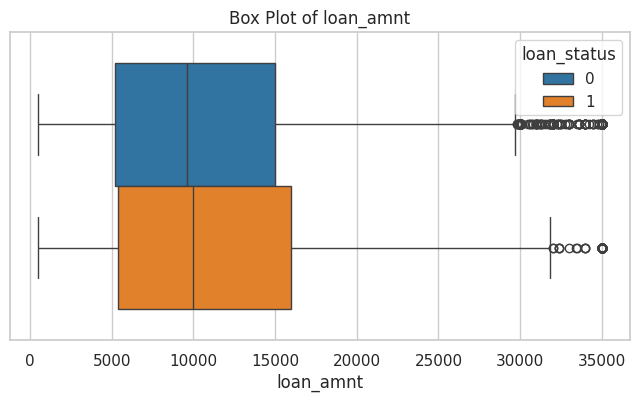

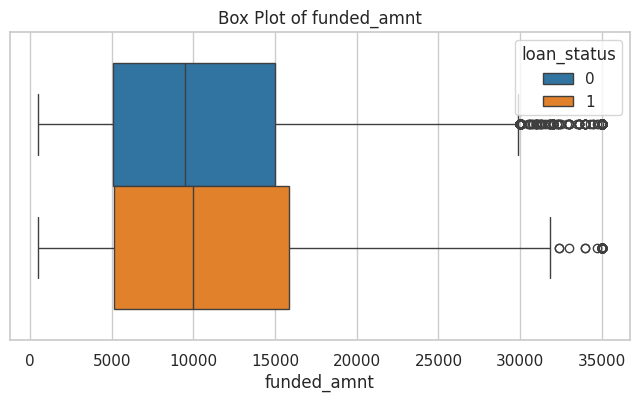

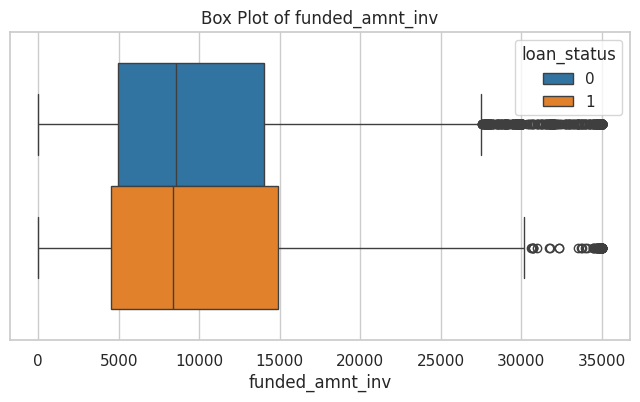

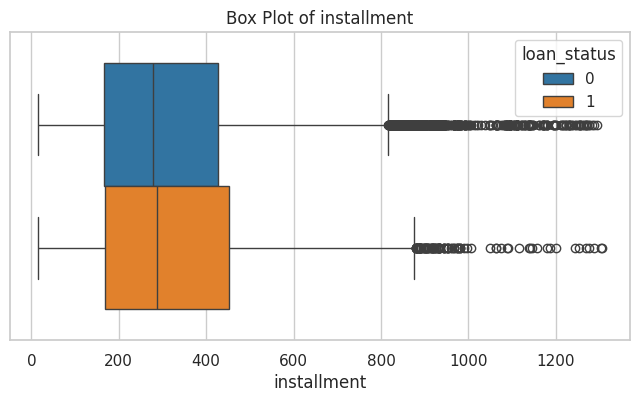

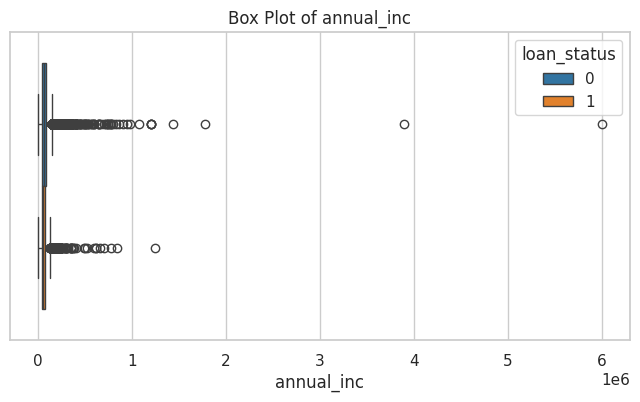

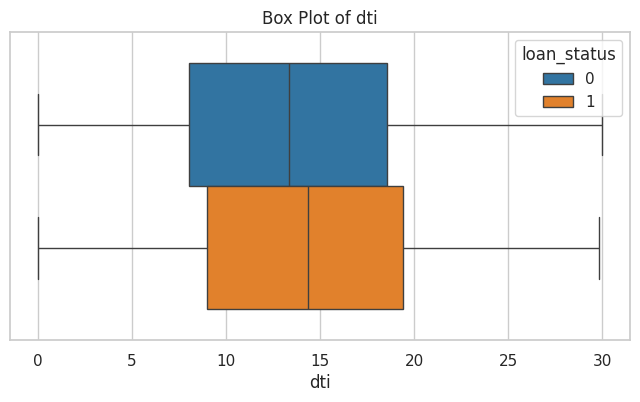

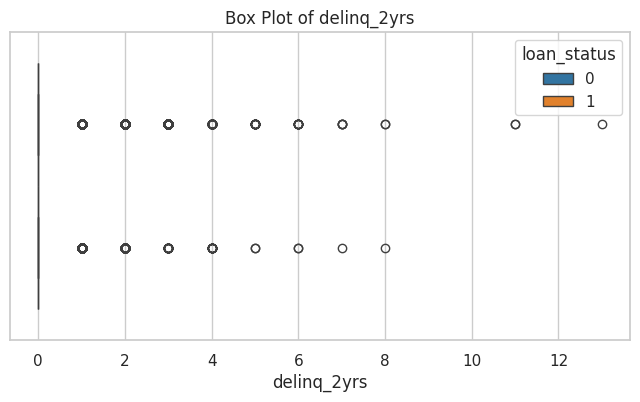

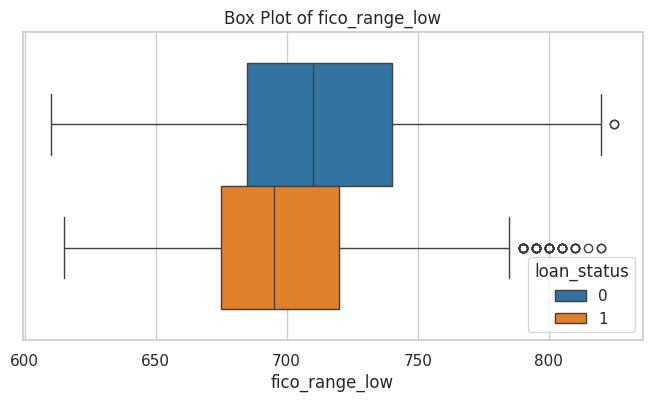

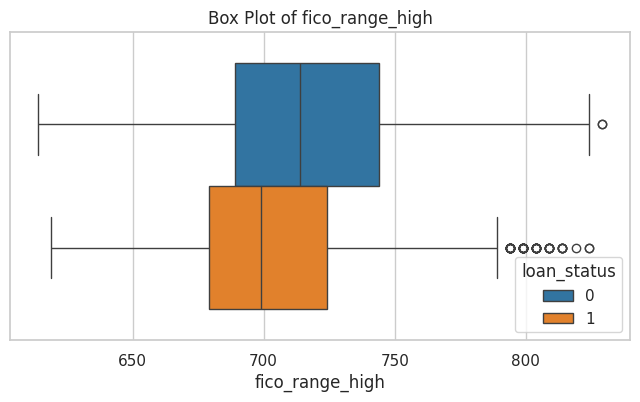

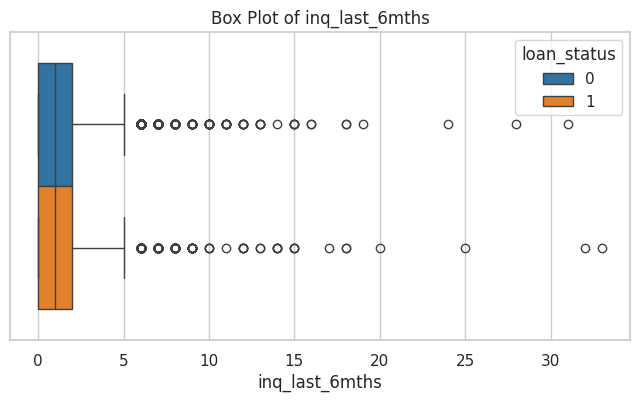

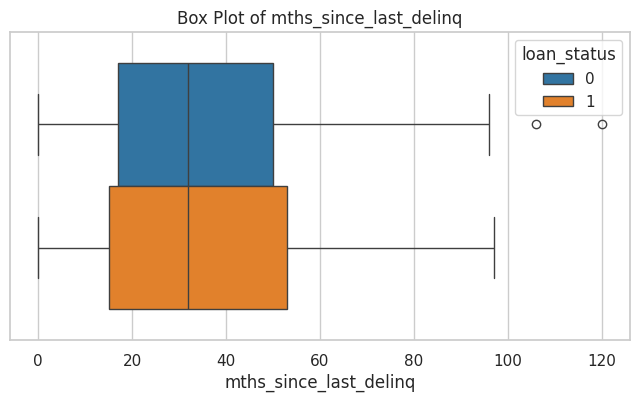

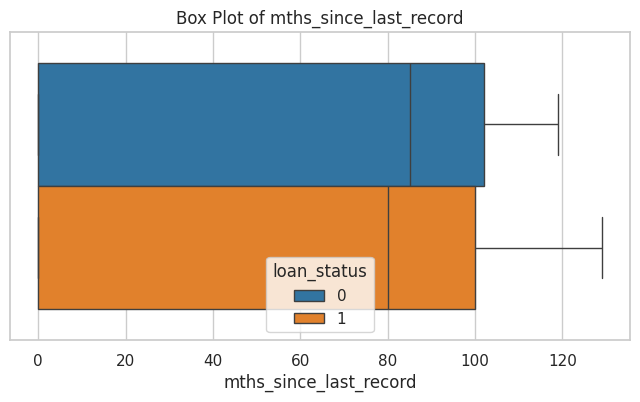

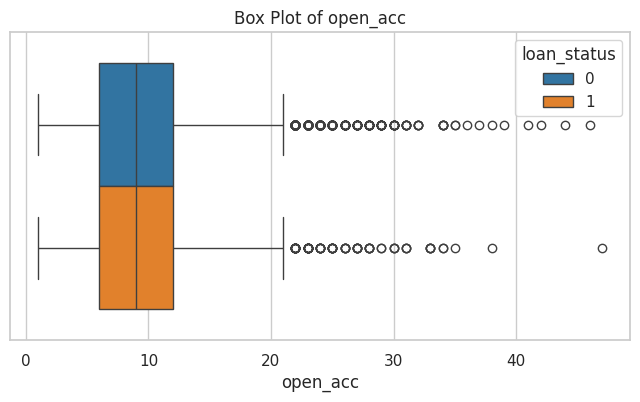

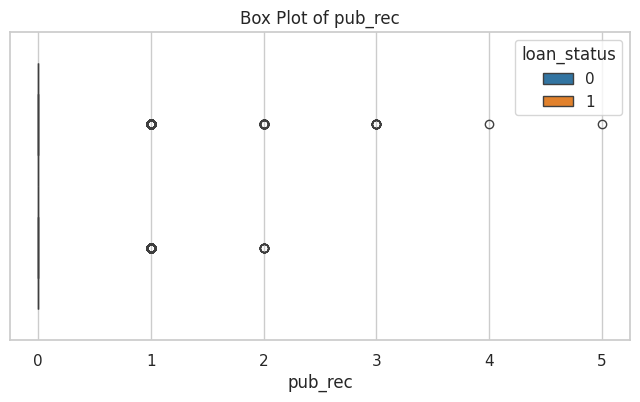

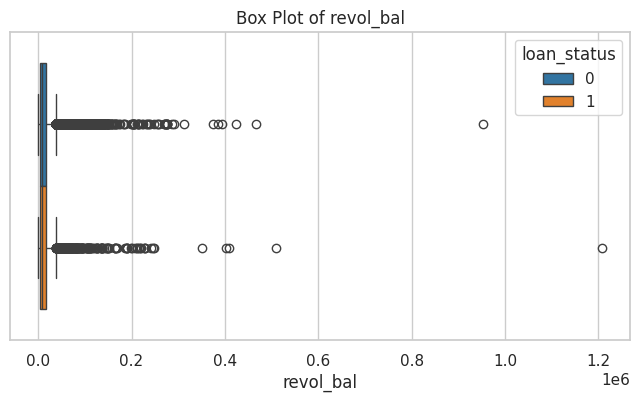

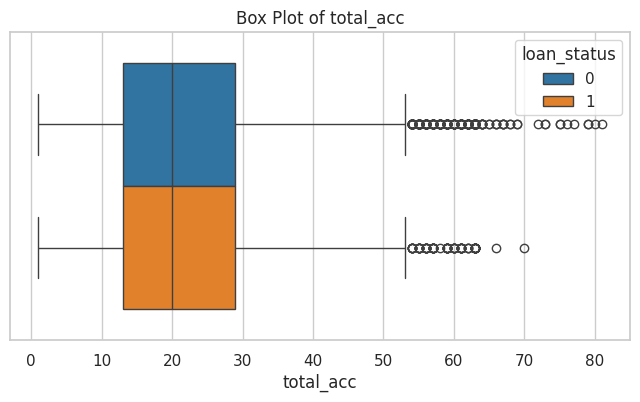

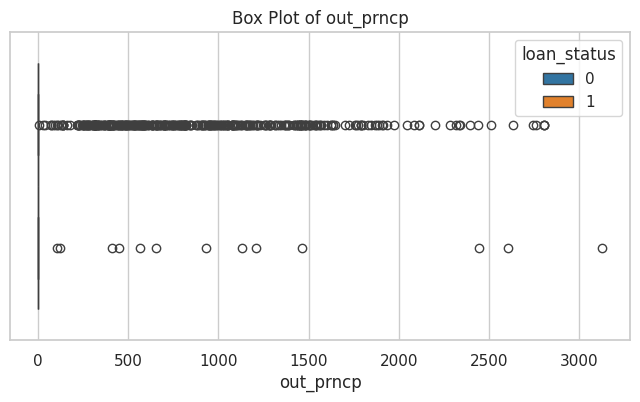

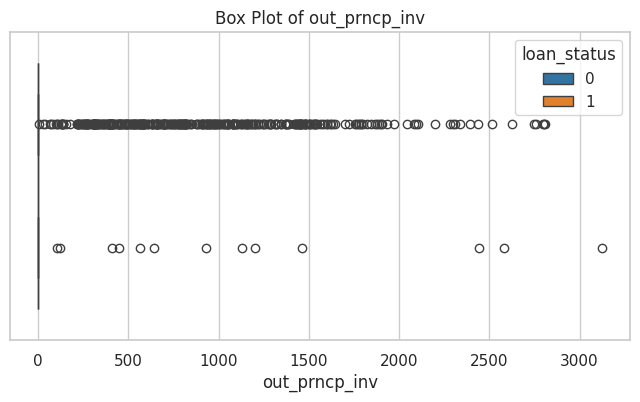

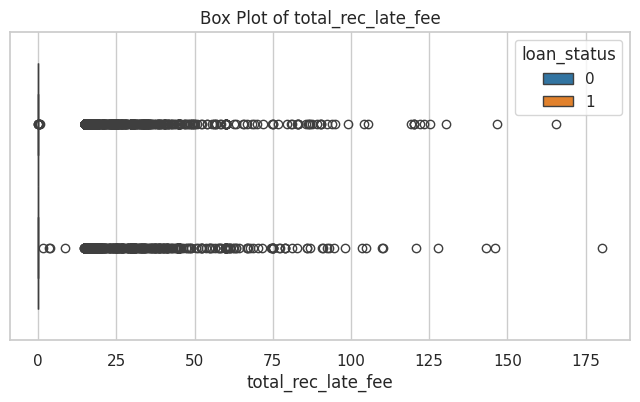

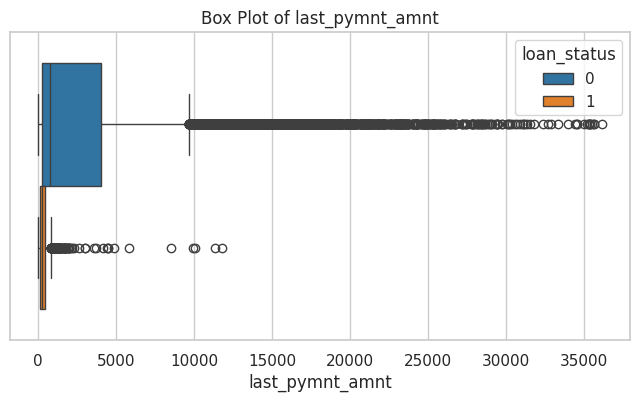

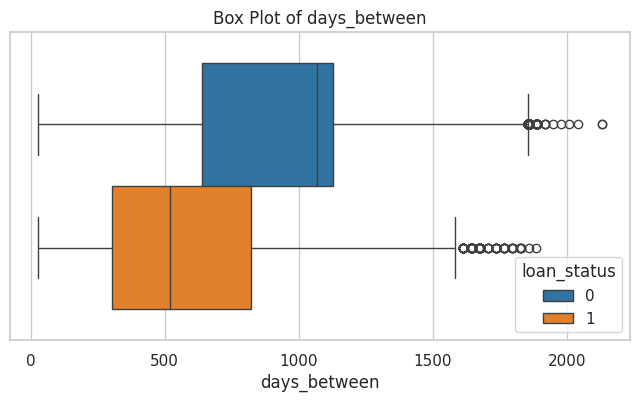

In [ ]:
for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=loan, x=feature, hue="loan_status")
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(feature)
    plt.show()

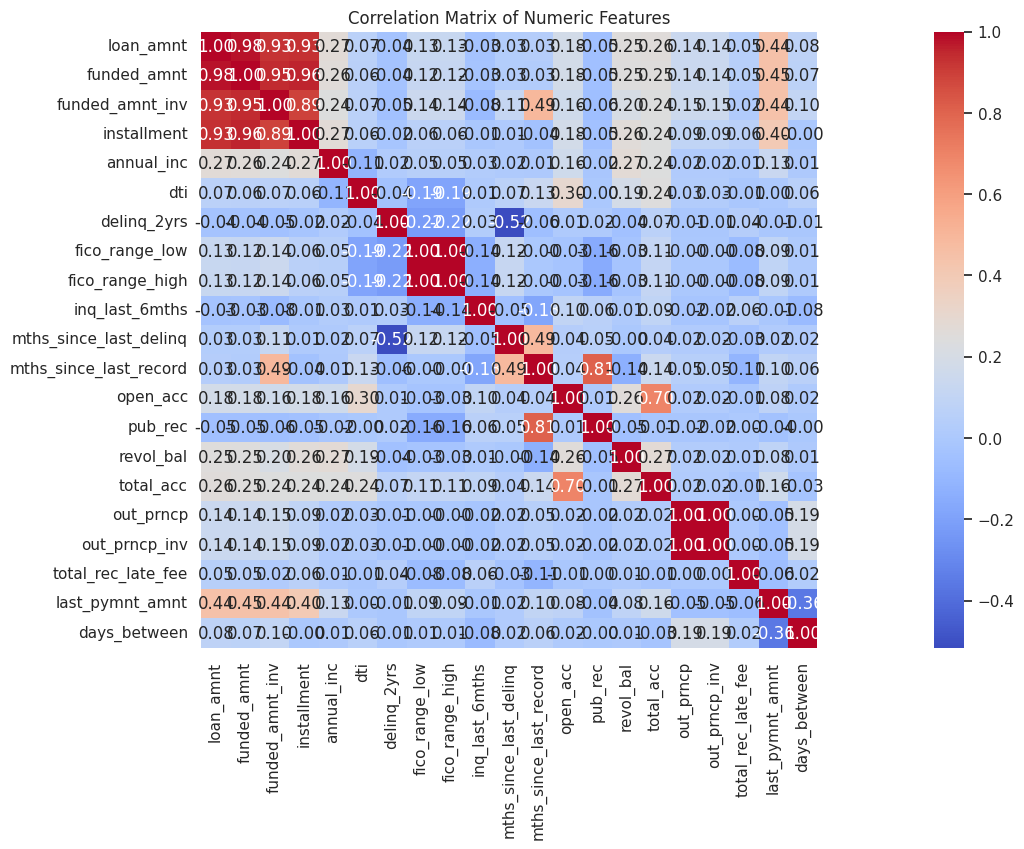

In [ ]:
# Compute the correlation matrix
corr = loan[numeric_features].corr()

# Generate a heatmap
plt.figure(figsize=(30, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

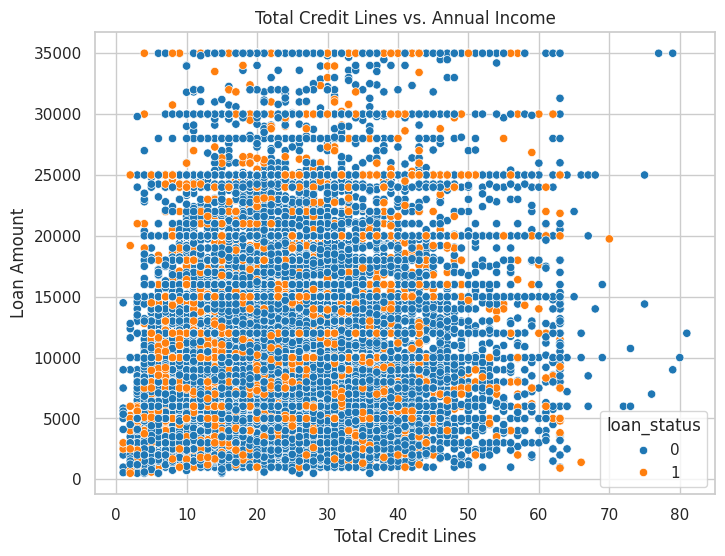

In [ ]:
# Example scatter plot between 'total_acc' and 'loan_amnt'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=loan, x='total_acc', y='loan_amnt', hue='loan_status')
plt.title('Total Credit Lines vs. Annual Income')
plt.xlabel('Total Credit Lines')
plt.ylabel('Loan Amount')
plt.show()

## Categorical Exploration

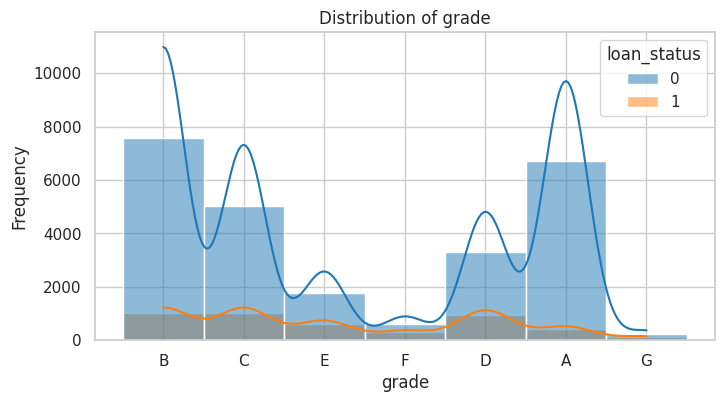

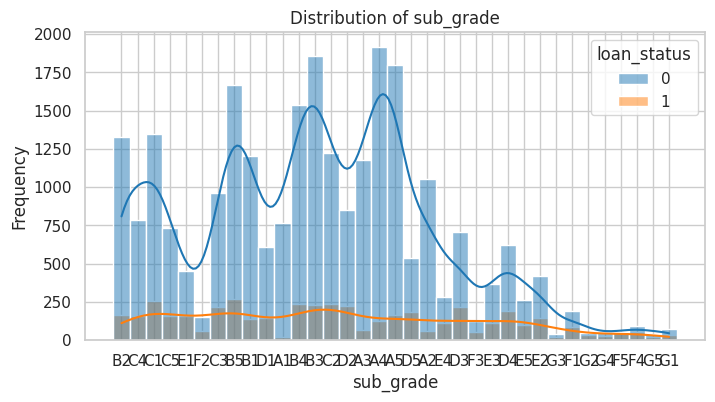

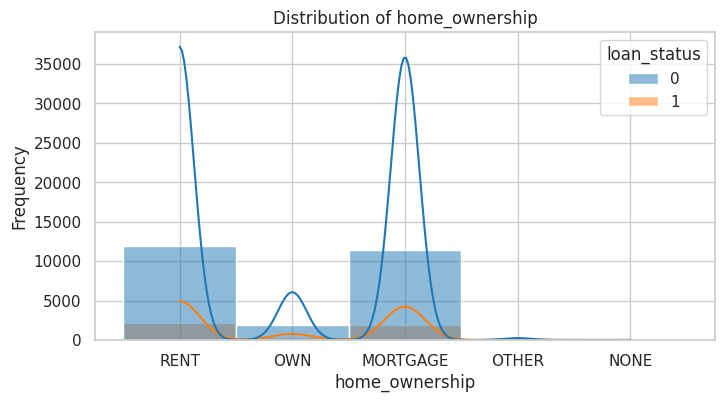

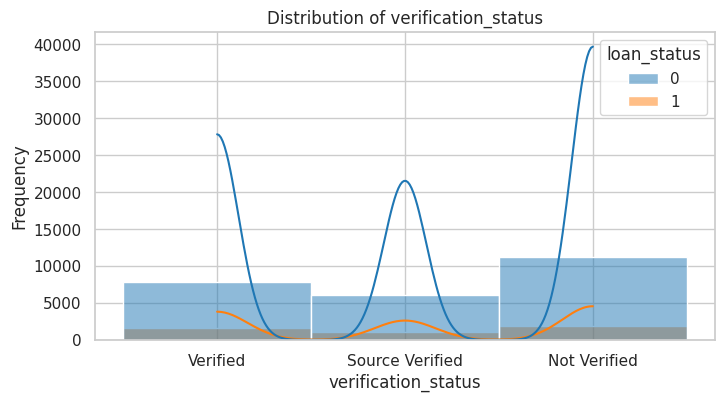

In [ ]:
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data= loan, x=feature, hue="loan_status", kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

## Spread of loan_status

In [ ]:
loan['loan_status'].value_counts()

current    25300
default     4477
Name: loan_status, dtype: int64

Text(0.5, 1.0, 'Distribution of Current or Default')

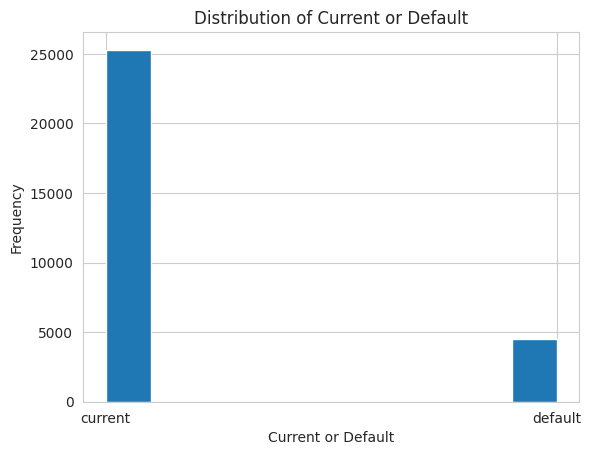

In [ ]:
loan['loan_status'].hist()

plt.xlabel('Current or Default')
plt.ylabel('Frequency')
plt.title('Distribution of Current or Default')

# Baseline Models

## Preprocessing

In [ ]:
loan[target] = loan[target].map({'current': 0, 'default': 1})
loan[target].value_counts()

loan_status
0    25300
1     4477
Name: count, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(loan[numeric_features + categorical_features], loan[target], test_size=0.2, random_state=42)

## Baseline Stacking Classifier

In [ ]:
# create transformers

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# base estimators for stacker
base_estimators = [
    ('gbm', GradientBoostingClassifier(n_estimators=30, learning_rate=1.0, max_depth=3, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=25, random_state=42)),
    ('nn', MLPClassifier(random_state=42))
]

# final estimator on top
final_estimator = LogisticRegression()

stacking_classifier = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    cv=3,
    n_jobs=-1
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', stacking_classifier)])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'funded_amnt',
                                                   'funded_amnt_inv',
                                                   'installment', 'annual_inc',
                                                   'dti', 'delinq_2yrs',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths',
                                                   'mths_since_last_delinq',
                                                   'mths_since_last_re...
                                                  ['grade', 'sub_grade',
                                                   'home_ownership',
                                                   'verification_status'])])),
                ('classifier',
                 StackingClassifier(cv=3,
                                    estimators=[('gbm',
                                                 GradientBoostingClassifier(learning_rate=1.0,
                                                                            n_estimators=30,
                                                                            random_state=42)),
                                                ('rf',
                                                 RandomForestClassifier(n_estimators=25,
                                                                        random_state=42)),
                                                ('nn',
                                                 MLPClassifier(random_state=42))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1))])

### Model Performance

In [ ]:
# Predictions for the training set
y_train_pred = pipeline.predict(X_train)
y_train_prob = pipeline.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = pipeline.predict(X_test)
y_test_prob = pipeline.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")

Training Metrics:
Accuracy: 0.99
Precision (default): 0.96
Recall (default): 0.95
F1 Score (default): 0.95
AUC: 1.00

Test Metrics:
Accuracy: 0.96
Precision (default): 0.87
Recall (default): 0.86
F1 Score (default): 0.87
AUC: 0.98


## Baseline Neural Net

In [ ]:
# Define the MLP pipeline
mlp_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', MLPClassifier(hidden_layer_sizes=50, activation='relu'))])

# Train the MLP model
mlp_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
mlp_predictions = mlp_pipeline.predict(X_test)
mlp_predictions_proba = mlp_pipeline.predict_proba(X_test)[:,1]
print(f"MLP Accuracy: {accuracy_score(y_test, mlp_predictions):.4f}")

MLP Accuracy: 0.9308


### Model Performance

In [ ]:
# Predictions for the training set
y_train_pred = mlp_pipeline.predict(X_train)
y_train_prob = mlp_pipeline.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = mlp_pipeline.predict(X_test)
y_test_prob = mlp_pipeline.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")

Training Metrics:
Accuracy: 0.96
Precision (default): 0.88
Recall (default): 0.87
F1 Score (default): 0.88
AUC: 0.99

Test Metrics:
Accuracy: 0.93
Precision (default): 0.77
Recall (default): 0.75
F1 Score (default): 0.76
AUC: 0.96


## Baseline Logistic Regression

In [ ]:
# Define the Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=0, max_iter=300))])

# Train the Logistic Regression model
lr_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
lr_predictions = lr_pipeline.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")

Logistic Regression Accuracy: 0.9209


### Model Performance

In [ ]:
# Predictions for the training set
y_train_pred = lr_pipeline.predict(X_train)
y_train_prob = lr_pipeline.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = lr_pipeline.predict(X_test)
y_test_prob = lr_pipeline.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")

Training Metrics:
Accuracy: 0.92
Precision (default): 0.79
Recall (default): 0.67
F1 Score (default): 0.73
AUC: 0.96

Test Metrics:
Accuracy: 0.92
Precision (default): 0.77
Recall (default): 0.66
F1 Score (default): 0.71
AUC: 0.95


## Baseline Random Forest

In [ ]:
# Define the Random Forest pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=50, n_jobs = -1, random_state=0))])

# Train the Random Forest model
rf_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
rf_predictions = rf_pipeline.predict(X_test)
rf_predictions_proba = rf_pipeline.predict_proba(X_test)[:,1]
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")

Random Forest Accuracy: 0.9412


### Model Performance

In [ ]:
# Predictions for the training set
y_train_pred = rf_pipeline.predict(X_train)
y_train_prob = rf_pipeline.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = rf_pipeline.predict(X_test)
y_test_prob = rf_pipeline.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")

Training Metrics:
Accuracy: 1.00
Precision (default): 1.00
Recall (default): 1.00
F1 Score (default): 1.00
AUC: 1.00

Test Metrics:
Accuracy: 0.94
Precision (default): 0.87
Recall (default): 0.70
F1 Score (default): 0.78
AUC: 0.97


## Baseline GBM

In [ ]:
# Define the Gradient Boosting pipeline
gbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(learning_rate=0.1, n_estimators=100))])

# Train the Gradient Boosting model
gbm_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
gbm_predictions = gbm_pipeline.predict(X_test)
gbm_predictions_proba = gbm_pipeline.predict_proba(X_test)[:,1]
print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, gbm_predictions):.4f}")

Gradient Boosting Accuracy: 0.9528


### Model Performance

In [ ]:
# Predictions for the training set
y_train_pred = gbm_pipeline.predict(X_train)
y_train_prob = gbm_pipeline.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = gbm_pipeline.predict(X_test)
y_test_prob = gbm_pipeline.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")

Training Metrics:
Accuracy: 0.96
Precision (default): 0.86
Recall (default): 0.88
F1 Score (default): 0.87
AUC: 0.99

Test Metrics:
Accuracy: 0.95
Precision (default): 0.83
Recall (default): 0.86
F1 Score (default): 0.84
AUC: 0.98


# Parameter Tuning

## Neural Net

In [ ]:
# Create the parameter grid
param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'classifier__activation': ['relu', 'tanh', 'logistic'],
    'classifier__solver': ['adam', 'sgd', 'lbfgs'],
    'classifier__max_iter': [100, 200, 300],
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(mlp_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters:
  classifier__activation: logistic
  classifier__hidden_layer_sizes: (50,)
  classifier__max_iter: 100
  classifier__solver: adam


## Logistic Regression

In [ ]:
# Create the parameter grid
param_grid = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['saga', 'liblinear'],
    'classifier__max_iter': [50, 100, 200]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(lr_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters:
  classifier__C: 1
  classifier__max_iter: 50
  classifier__penalty: l1
  classifier__solver: liblinear


## Random Forest

In [ ]:
# Create the parameter grid
param_grid = {
    'classifier__n_estimators': [20, 30, 50],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [ 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters:
  classifier__max_depth: None
  classifier__min_samples_leaf: 1
  classifier__min_samples_split: 10
  classifier__n_estimators: 50


## GBM

In [ ]:
# Create the parameter grid
param_grid = {
    'classifier__n_estimators': [10, 100, 200],
    'classifier__learning_rate': [0.05, 0.1, 0.2]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(gbm_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters:
  classifier__learning_rate: 0.2
  classifier__n_estimators: 200


## Stacking Classifier

I will take all the tuned parameters from the individual models and throw those into my tuned model for the stacking model.

# Tuned Models

## Tuned Neural Net

In [ ]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
mlp_pipeline_hpo = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', MLPClassifier(activation='logistic',
                                                           hidden_layer_sizes=(50,),
                                                           max_iter=100,
                                                           solver='adam'))])
# Train the pipeline
mlp_pipeline_hpo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'funded_amnt',
                                                   'funded_amnt_inv',
                                                   'installment', 'annual_inc',
                                                   'dti', 'delinq_2yrs',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths',
                                                   'mths_since_last_delinq',
                                                   'mths_since_last_re...
                                                   'total_rec_late_fee',
                                                   'last_pymnt_amnt',
                                                   'days_between']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['grade', 'sub_grade',
                                                   'home_ownership',
                                                   'verification_status'])])),
                ('classifier',
                 MLPClassifier(activation='logistic', hidden_layer_sizes=(50,),
                               max_iter=100))])

### Model Performance

In [ ]:
# Predictions for the training set
y_train_pred = mlp_pipeline_hpo.predict(X_train)
y_train_prob = mlp_pipeline_hpo.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = mlp_pipeline_hpo.predict(X_test)
y_test_prob = mlp_pipeline_hpo.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")

Training Metrics:
Accuracy: 0.94
Precision (default): 0.80
Recall (default): 0.79
F1 Score (default): 0.80
AUC: 0.97

Test Metrics:
Accuracy: 0.93
Precision (default): 0.78
Recall (default): 0.78
F1 Score (default): 0.78
AUC: 0.96


### Feature Importance

In [ ]:
# Predict probabilities for the positive class
y_scores = mlp_pipeline_hpo.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")

Target FPR: 0.01, Expected TPR: 0.4302, Threshold: 0.8221
Target FPR: 0.02, Expected TPR: 0.5675, Threshold: 0.7166
Target FPR: 0.03, Expected TPR: 0.7037, Threshold: 0.5844
Target FPR: 0.04, Expected TPR: 0.7855, Threshold: 0.4641
Target FPR: 0.05, Expected TPR: 0.8400, Threshold: 0.3592
Target FPR: 0.06, Expected TPR: 0.8922, Threshold: 0.2469
Target FPR: 0.07, Expected TPR: 0.9137, Threshold: 0.1967
Target FPR: 0.08, Expected TPR: 0.9308, Threshold: 0.1541
Target FPR: 0.09, Expected TPR: 0.9410, Threshold: 0.1240
Target FPR: 0.10, Expected TPR: 0.9478, Threshold: 0.1089


In [ ]:
# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Display the DataFrame
target_fpr_df

Target FPR (%)  Expected TPR  Threshold
0             1.0      0.430193   0.822122
1             2.0      0.567537   0.716622
2             3.0      0.703746   0.584387
3             4.0      0.785471   0.464115
4             5.0      0.839955   0.359152
5             6.0      0.892168   0.246886
6             7.0      0.913734   0.196741
7             8.0      0.930760   0.154146
8             9.0      0.940976   0.124024
9            10.0      0.947787   0.108928

Here I decided to use permutation importance because mlp classifiers do not have a feature importance attribute. This still shows which ones are more important.

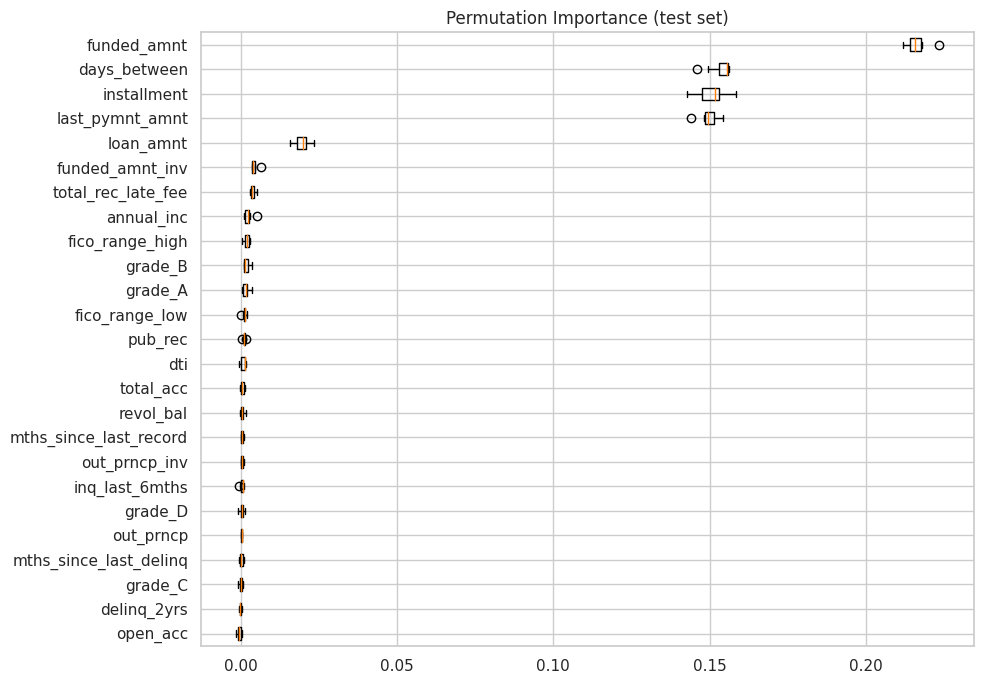

In [ ]:
# Compute permutation importance
result = permutation_importance(mlp_pipeline_hpo, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)

# Function to get feature names from column transformer
def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    output_features = []

    # Loop through each transformer in the column transformer
    for name, pipe, features in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if hasattr(pipe, 'get_feature_names_out'):
            # If the transformer has a get_feature_names_out method, use it
            if hasattr(pipe, 'categories_'):
                feature_names = pipe.get_feature_names_out(features)
            else:
                feature_names = pipe.get_feature_names_out()
        else:
            # Otherwise, use the provided feature names
            feature_names = features
        output_features.extend(feature_names)
    return output_features

# Extract feature names from the preprocessor
feature_names = get_feature_names(preprocessor)

# Now using feature_names with sorted_idx for labeling in the plot
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 7))
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.tight_layout()
plt.show()

## Tuned Logistic Regression

In [ ]:
# Define the Logistic Regression pipeline
lr_pipeline_hpo = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=0,
                                                                max_iter=50,
                                                                C=1,
                                                                penalty='l1',
                                                                solver='liblinear'))])

# Train the pipeline
lr_pipeline_hpo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'funded_amnt',
                                                   'funded_amnt_inv',
                                                   'installment', 'annual_inc',
                                                   'dti', 'delinq_2yrs',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths',
                                                   'mths_since_last_delinq',
                                                   'mths_since_last_re...
                                                   'total_rec_late_fee',
                                                   'last_pymnt_amnt',
                                                   'days_between']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['grade', 'sub_grade',
                                                   'home_ownership',
                                                   'verification_status'])])),
                ('classifier',
                 LogisticRegression(C=1, max_iter=50, penalty='l1',
                                    random_state=0, solver='liblinear'))])

### Model Performance

In [ ]:
# Predictions for the training set
y_train_pred = lr_pipeline_hpo.predict(X_train)
y_train_prob = lr_pipeline_hpo.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = lr_pipeline_hpo.predict(X_test)
y_test_prob = lr_pipeline_hpo.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")

Training Metrics:
Accuracy: 0.92
Precision (default): 0.79
Recall (default): 0.67
F1 Score (default): 0.73
AUC: 0.96

Test Metrics:
Accuracy: 0.92
Precision (default): 0.77
Recall (default): 0.66
F1 Score (default): 0.71
AUC: 0.95


### Feature Importance

In [ ]:
# prompt: extract feature names and position from pipeline to do logisic feature importance

feature_names = preprocessor.get_feature_names_out()
feature_importance = lr_pipeline_hpo.named_steps['classifier'].coef_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance[0]})
feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

feature  importance
0       num__funded_amnt    3.786136
1           cat__grade_F    0.612554
2           cat__grade_G    0.555973
3      cat__sub_grade_A5    0.541927
4      cat__sub_grade_E5    0.396701
..                   ...         ...
70          cat__grade_B   -0.786468
71          cat__grade_A   -1.774982
72     num__days_between   -2.017555
73      num__installment   -3.086451
74  num__last_pymnt_amnt   -9.506949

[75 rows x 2 columns]

In [ ]:
# Logistic Regression coefficients as feature importance
lr_coefficients = lr_pipeline_hpo.named_steps['classifier'].coef_[0]

# Aligning feature names and coefficients
lr_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr_coefficients})
lr_feature_importance_df = lr_feature_importance_df.sort_values(by='Coefficient', ascending=False)
lr_feature_importance_df.head(10)

Feature  Coefficient
1                           num__funded_amnt     3.786136
26                              cat__grade_F     0.612554
27                              cat__grade_G     0.555973
33                         cat__sub_grade_A5     0.541927
53                         cat__sub_grade_E5     0.396701
52                         cat__sub_grade_E4     0.357141
48                         cat__sub_grade_D5     0.300607
18                   num__total_rec_late_fee     0.293271
62                         cat__sub_grade_G4     0.238802
72  cat__verification_status_Source Verified     0.181898

## Tuned Random Forest

In [ ]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
rf_pipeline_hpo = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=50,
                                                                    min_samples_split=10,
                                                                    min_samples_leaf=1,
                                                                    max_depth = None,
                                                                    n_jobs=-1,
                                                                    random_state=0))])
# Train the pipeline
rf_pipeline_hpo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'funded_amnt',
                                                   'funded_amnt_inv',
                                                   'installment', 'annual_inc',
                                                   'dti', 'delinq_2yrs',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths',
                                                   'mths_since_last_delinq',
                                                   'mths_since_last_re...
                                                   'total_rec_late_fee',
                                                   'last_pymnt_amnt',
                                                   'days_between']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['grade', 'sub_grade',
                                                   'home_ownership',
                                                   'verification_status'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=10, n_estimators=50,
                                        n_jobs=-1, random_state=0))])

### Model Performance

In [ ]:
# Predictions for the training set
y_train_pred = rf_pipeline_hpo.predict(X_train)
y_train_prob = rf_pipeline_hpo.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = rf_pipeline_hpo.predict(X_test)
y_test_prob = rf_pipeline_hpo.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")

Training Metrics:
Accuracy: 0.98
Precision (default): 0.99
Recall (default): 0.90
F1 Score (default): 0.95
AUC: 1.00

Test Metrics:
Accuracy: 0.94
Precision (default): 0.88
Recall (default): 0.72
F1 Score (default): 0.79
AUC: 0.97


### Feature Importance

In [ ]:
# Predict probabilities for the positive class
y_scores = rf_pipeline_hpo.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")

Target FPR: 0.01, Expected TPR: 0.5846, Threshold: 0.5772
Target FPR: 0.02, Expected TPR: 0.7355, Threshold: 0.4712
Target FPR: 0.03, Expected TPR: 0.8059, Threshold: 0.4028
Target FPR: 0.04, Expected TPR: 0.8400, Threshold: 0.3406
Target FPR: 0.05, Expected TPR: 0.8672, Threshold: 0.2919
Target FPR: 0.06, Expected TPR: 0.8978, Threshold: 0.2612
Target FPR: 0.07, Expected TPR: 0.9183, Threshold: 0.2333
Target FPR: 0.08, Expected TPR: 0.9285, Threshold: 0.2138
Target FPR: 0.09, Expected TPR: 0.9330, Threshold: 0.1986
Target FPR: 0.10, Expected TPR: 0.9410, Threshold: 0.1826


In [ ]:
# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Display the DataFrame
target_fpr_df

Target FPR (%)  Expected TPR  Threshold
0             1.0      0.584563   0.577156
1             2.0      0.735528   0.471160
2             3.0      0.805902   0.402768
3             4.0      0.839955   0.340619
4             5.0      0.867196   0.291934
5             6.0      0.897843   0.261210
6             7.0      0.918275   0.233332
7             8.0      0.928490   0.213809
8             9.0      0.933031   0.198610
9            10.0      0.940976   0.182637

In [ ]:
# Adjusting the feature name extraction for OneHotEncoder to use get_feature_names_out
feature_names = list(preprocessor.transformers_[0][2]) + \
    list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

rf_importances = rf_pipeline_hpo.named_steps['classifier'].feature_importances_

# Display the top 10 features
rf_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)
rf_feature_importance_df.head(10)

Feature  Importance
19     last_pymnt_amnt    0.285444
20        days_between    0.262056
18  total_rec_late_fee    0.044693
3          installment    0.031515
4           annual_inc    0.030107
2      funded_amnt_inv    0.029435
5                  dti    0.026223
14           revol_bal    0.026102
0            loan_amnt    0.025131
1          funded_amnt    0.025041

## Tuned GBM

In [ ]:
gbm_pipeline_hpo = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', GradientBoostingClassifier(learning_rate=0.2,
                                                                          n_estimators=200))])

# Train the pipeline
gbm_pipeline_hpo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'funded_amnt',
                                                   'funded_amnt_inv',
                                                   'installment', 'annual_inc',
                                                   'dti', 'delinq_2yrs',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths',
                                                   'mths_since_last_delinq',
                                                   'mths_since_last_re...
                                                   'out_prncp', 'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'last_pymnt_amnt',
                                                   'days_between']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['grade', 'sub_grade',
                                                   'home_ownership',
                                                   'verification_status'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.2,
                                            n_estimators=200))])

### Model Performance

In [ ]:
# Predictions for the training set
y_train_pred =gbm_pipeline_hpo.predict(X_train)
y_train_prob = gbm_pipeline_hpo.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = gbm_pipeline_hpo.predict(X_test)
y_test_prob = gbm_pipeline_hpo.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")

Training Metrics:
Accuracy: 0.98
Precision (default): 0.91
Recall (default): 0.94
F1 Score (default): 0.93
AUC: 0.99

Test Metrics:
Accuracy: 0.96
Precision (default): 0.86
Recall (default): 0.90
F1 Score (default): 0.88
AUC: 0.98


### Feature Importance

In [ ]:
# Predict probabilities for the positive class
y_scores = gbm_pipeline_hpo.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")

Target FPR: 0.01, Expected TPR: 0.7367, Threshold: 0.7883
Target FPR: 0.02, Expected TPR: 0.8695, Threshold: 0.5993
Target FPR: 0.03, Expected TPR: 0.9160, Threshold: 0.4254
Target FPR: 0.04, Expected TPR: 0.9467, Threshold: 0.2633
Target FPR: 0.05, Expected TPR: 0.9637, Threshold: 0.1348
Target FPR: 0.06, Expected TPR: 0.9694, Threshold: 0.0788
Target FPR: 0.07, Expected TPR: 0.9762, Threshold: 0.0507
Target FPR: 0.08, Expected TPR: 0.9796, Threshold: 0.0352
Target FPR: 0.09, Expected TPR: 0.9807, Threshold: 0.0269
Target FPR: 0.10, Expected TPR: 0.9807, Threshold: 0.0243


In [ ]:
# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Display the DataFrame
target_fpr_df

Target FPR (%)  Expected TPR  Threshold
0             1.0      0.736663   0.788261
1             2.0      0.869467   0.599297
2             3.0      0.916005   0.425393
3             4.0      0.946652   0.263322
4             5.0      0.963678   0.134817
5             6.0      0.969353   0.078840
6             7.0      0.976163   0.050707
7             8.0      0.979569   0.035235
8             9.0      0.980704   0.026931
9            10.0      0.980704   0.024250

In [ ]:
# Adjusting the feature name extraction for OneHotEncoder to use get_feature_names_out
feature_names = list(preprocessor.transformers_[0][2]) + \
    list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

gbm_importances = gbm_pipeline_hpo.named_steps['classifier'].feature_importances_

# Display the top 10 features
gbm_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbm_importances})
gbm_feature_importance_df = gbm_feature_importance_df.sort_values(by='Importance', ascending=False)
gbm_feature_importance_df.head(10)

Feature  Importance
20        days_between    0.551449
19     last_pymnt_amnt    0.340893
18  total_rec_late_fee    0.042219
3          installment    0.020044
21             grade_A    0.009979
0            loan_amnt    0.007563
2      funded_amnt_inv    0.005385
1          funded_amnt    0.003466
25             grade_E    0.001943
4           annual_inc    0.001851

## Tuned Stacking Classifier

In [ ]:
# create transformers

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# base estimators for stacker
base_estimators = [
    ('gbm', GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_depth=3, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_depth = None, random_state=42)),
    ('nn', MLPClassifier(activation='logistic', hidden_layer_sizes=(50,), max_iter=100, solver='adam', random_state=42))
]

# final estimator on top
final_estimator = LogisticRegression()

stacking_classifier = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    cv=3,
    n_jobs=-1
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', stacking_classifier)])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'funded_amnt',
                                                   'funded_amnt_inv',
                                                   'installment', 'annual_inc',
                                                   'dti', 'delinq_2yrs',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths',
                                                   'mths_since_last_delinq',
                                                   'mths_since_last_re...
                 StackingClassifier(cv=3,
                                    estimators=[('gbm',
                                                 GradientBoostingClassifier(learning_rate=0.2,
                                                                            n_estimators=200,
                                                                            random_state=42)),
                                                ('rf',
                                                 RandomForestClassifier(min_samples_split=10,
                                                                        n_estimators=50,
                                                                        random_state=42)),
                                                ('nn',
                                                 MLPClassifier(activation='logistic',
                                                               hidden_layer_sizes=(50,),
                                                               max_iter=100,
                                                               random_state=42))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1))])

### Model Performance

In [ ]:
# Predictions for the training set
y_train_pred = pipeline.predict(X_train)
y_train_prob = pipeline.predict_proba(X_train)[:, 1]

# Predictions for the test set
y_test_pred = pipeline.predict(X_test)
y_test_prob = pipeline.predict_proba(X_test)[:, 1]

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train).ravel()
y_test_binarized = lb.transform(y_test).ravel()

# Calculating metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, )
test_precision = precision_score(y_test, y_test_pred, )

train_recall = recall_score(y_train, y_train_pred, )
test_recall = recall_score(y_test, y_test_pred, )

train_f1 = f1_score(y_train, y_train_pred, )
test_f1 = f1_score(y_test, y_test_pred, )

train_auc = roc_auc_score(y_train_binarized, y_train_prob)
test_auc = roc_auc_score(y_test_binarized, y_test_prob)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision (default): {train_precision:.2f}")
print(f"Recall (default): {train_recall:.2f}")
print(f"F1 Score (default): {train_f1:.2f}")
print(f"AUC: {train_auc:.2f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision (default): {test_precision:.2f}")
print(f"Recall (default): {test_recall:.2f}")
print(f"F1 Score (default): {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")

Training Metrics:
Accuracy: 0.97
Precision (default): 0.92
Recall (default): 0.91
F1 Score (default): 0.92
AUC: 0.99

Test Metrics:
Accuracy: 0.96
Precision (default): 0.87
Recall (default): 0.89
F1 Score (default): 0.88
AUC: 0.98


### Feature Importance

In [ ]:
result = permutation_importance(pipeline, X_test, y_test,
                                n_repeats=10, random_state=42,
                                n_jobs=-1)

In [ ]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    feature_names = []

    # Loop through each transformer within the ColumnTransformer
    for name, transformer, columns in column_transformer.transformers_:
        if name == 'remainder':  # Skip the 'remainder' transformer, if present
            continue
        if isinstance(transformer, Pipeline):
            # If the transformer is a pipeline, get the last transformer from the pipeline
            transformer = transformer.steps[-1][1]

        if hasattr(transformer, 'get_feature_names_out'):
            # If the transformer has 'get_feature_names_out', use it
            names = list(transformer.get_feature_names_out(columns))
        else:
            # Otherwise, just use the column names directly
            names = list(columns)

        feature_names.extend(names)

    return feature_names

transformed_feature_names = get_feature_names(preprocessor)
transformed_feature_names

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_rec_late_fee',
 'last_pymnt_amnt',
 'days_between',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'grade_missing',
 'sub_grade_A1',
 'sub_grade_A2',
 'sub_grade_A3',
 'sub_grade_A4',
 'sub_grade_A5',
 'sub_grade_B1',
 'sub_grade_B2',
 'sub_grade_B3',
 'sub_grade_B4',
 'sub_grade_B5',
 'sub_grade_C1',
 'sub_grade_C2',
 'sub_grade_C3',
 'sub_grade_C4',
 'sub_grade_C5',
 'sub_grade_D1',
 'sub_grade_D2',
 'sub_grade_D3',
 'sub_grade_D4',
 'sub_grade_D5',
 'sub_grade_E1',
 'sub_grade_E2',
 'sub_grade_E3',
 'sub_grade_E4',
 'sub_grade_E5',
 'sub_grade_F1',
 'sub_grade_F2',
 'sub_grade_F3',
 'sub_grade_F4',
 'sub_grade_F5',
 'sub_grade_G1',
 'sub_gra

In [ ]:
feature_names = numeric_features + categorical_features

for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"Feature {feature_names[i]} "
              f"Mean Importance: {result.importances_mean[i]:.3f} "
              f"+/- {result.importances_std[i]:.3f}")

Feature days_between Mean Importance: 0.201 +/- 0.004
Feature last_pymnt_amnt Mean Importance: 0.179 +/- 0.004
Feature installment Mean Importance: 0.028 +/- 0.002
Feature funded_amnt Mean Importance: 0.016 +/- 0.001
Feature loan_amnt Mean Importance: 0.006 +/- 0.001
Feature total_rec_late_fee Mean Importance: 0.005 +/- 0.001
Feature grade Mean Importance: 0.003 +/- 0.001
Feature funded_amnt_inv Mean Importance: 0.002 +/- 0.000
Feature annual_inc Mean Importance: 0.002 +/- 0.001
Feature revol_bal Mean Importance: 0.001 +/- 0.000


In [ ]:
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,  # Or 'feature_names' if applicable
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False).reset_index(drop=True)
feature_importances_df

Feature  Importance Mean  Importance Std
0             days_between         0.201326        0.004347
1          last_pymnt_amnt         0.179248        0.004021
2              installment         0.027670        0.002256
3              funded_amnt         0.016353        0.000938
4                loan_amnt         0.005960        0.001425
5       total_rec_late_fee         0.005322        0.000688
6                    grade         0.002804        0.000869
7          funded_amnt_inv         0.002367        0.000453
8               annual_inc         0.001561        0.000713
9                revol_bal         0.000873        0.000317
10               total_acc         0.000520        0.000340
11  mths_since_last_delinq         0.000386        0.000344
12                 pub_rec         0.000302        0.000298
13                     dti         0.000252        0.000583
14  mths_since_last_record         0.000201        0.000196
15          inq_last_6mths         0.000151        0.000466
16     verification_status         0.000118        0.000226
17             delinq_2yrs         0.000000        0.000075
18               out_prncp        -0.000017        0.000090
19                open_acc        -0.000034        0.000165
20         fico_range_high        -0.000067        0.000384
21           out_prncp_inv        -0.000101        0.000111
22          fico_range_low        -0.000151        0.000265
23               sub_grade        -0.000168        0.000475
24          home_ownership        -0.000302        0.000210

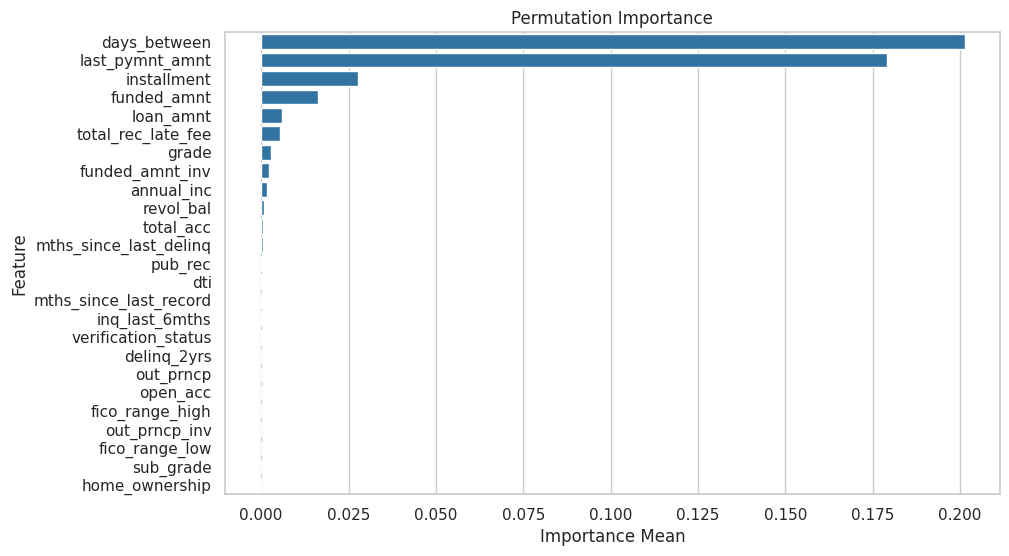

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(feature_importances_df, x='Importance Mean', y='Feature')
plt.title('Permutation Importance')
plt.show()

# AUC-ROC & PR Curves

## Neural Net

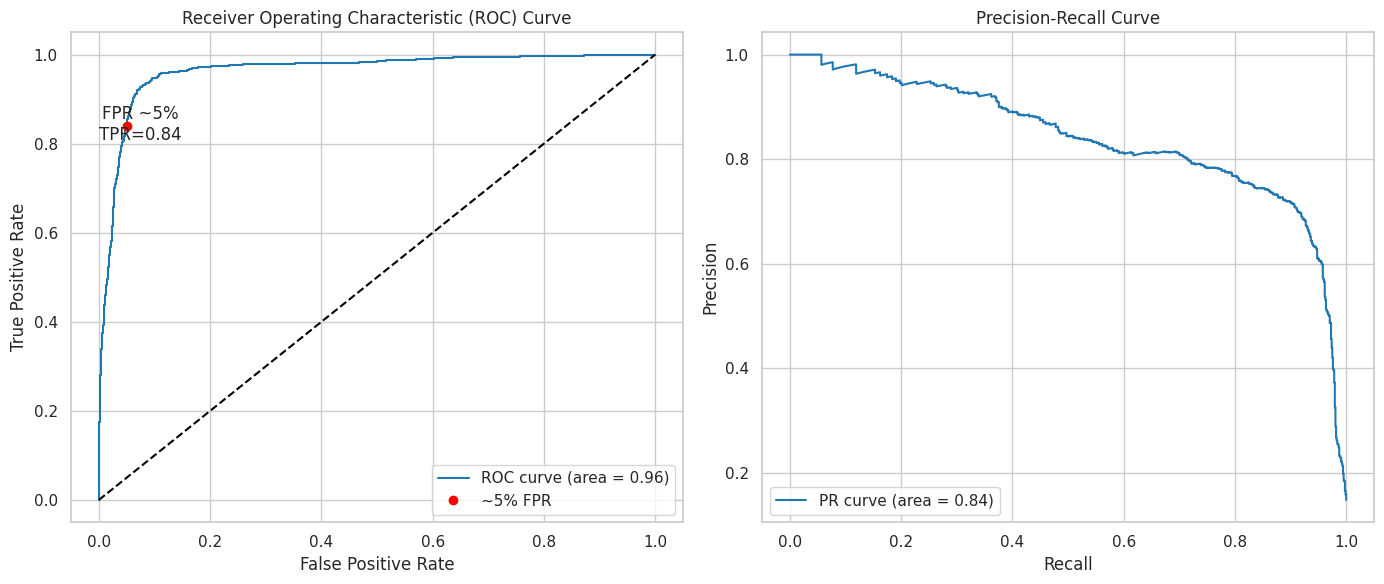

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_test_prob)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlighting the 5% FPR point
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index of the FPR just over 5%
plt.plot(fpr[idx], tpr[idx], 'ro', label='~5% FPR')  # 'ro' for red dot
plt.annotate(f'FPR ~5%\nTPR={tpr[idx]:.2f}', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


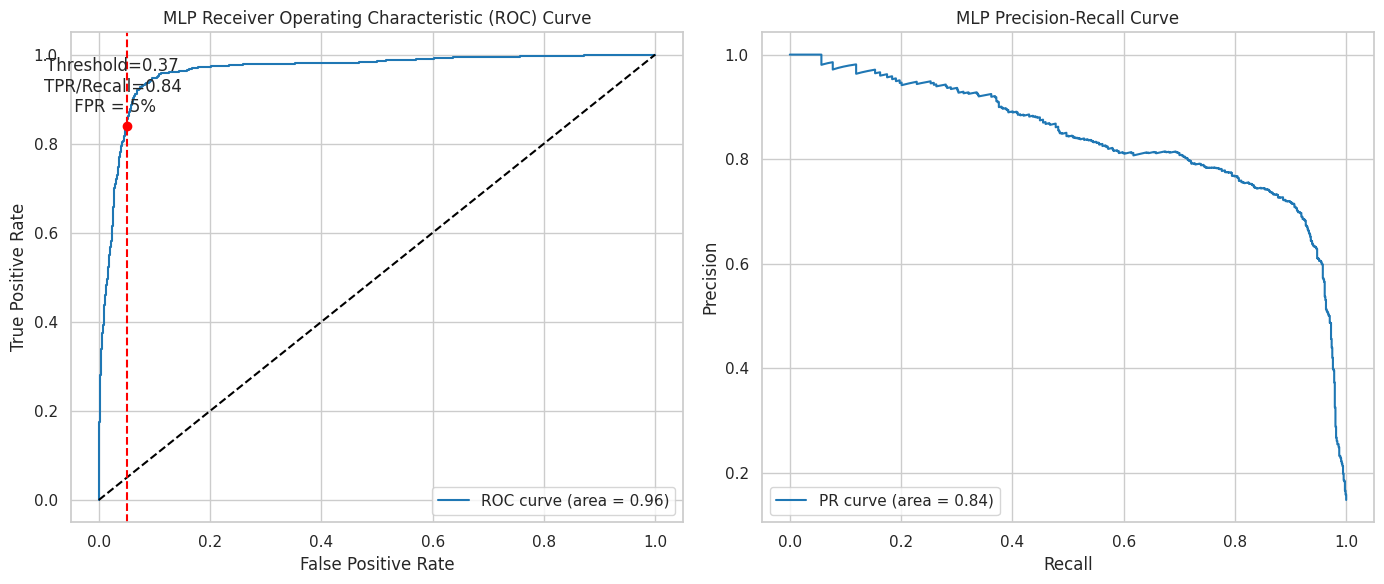

In [ ]:
# Assuming calculations for fpr, tpr, and thresholds_roc are already done

plt.figure(figsize=(14, 6))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlight the 5% FPR with a vertical line
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index for FPR just over 5%
plt.axvline(x=fpr[idx], color='r', linestyle='--')  # Vertical line for ~5% FPR
plt.plot(fpr[idx], tpr[idx], 'ro')  # Red dot at the intersection

# Adding a text annotation for the threshold
plt.annotate(f'Threshold={thresholds_roc[idx]:.2f}\nTPR/Recall={tpr[idx]:.2f}\n FPR = 5%', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('MLP Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

## Logistic Regression

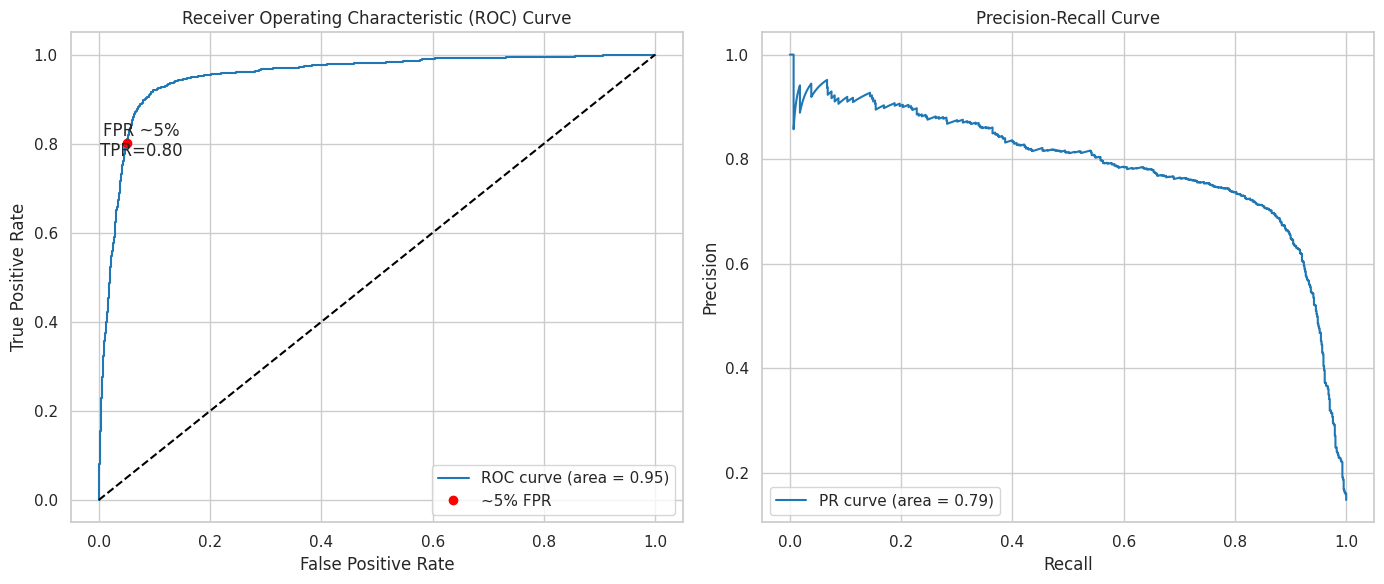

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_test_prob)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlighting the 5% FPR point
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index of the FPR just over 5%
plt.plot(fpr[idx], tpr[idx], 'ro', label='~5% FPR')  # 'ro' for red dot
plt.annotate(f'FPR ~5%\nTPR={tpr[idx]:.2f}', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

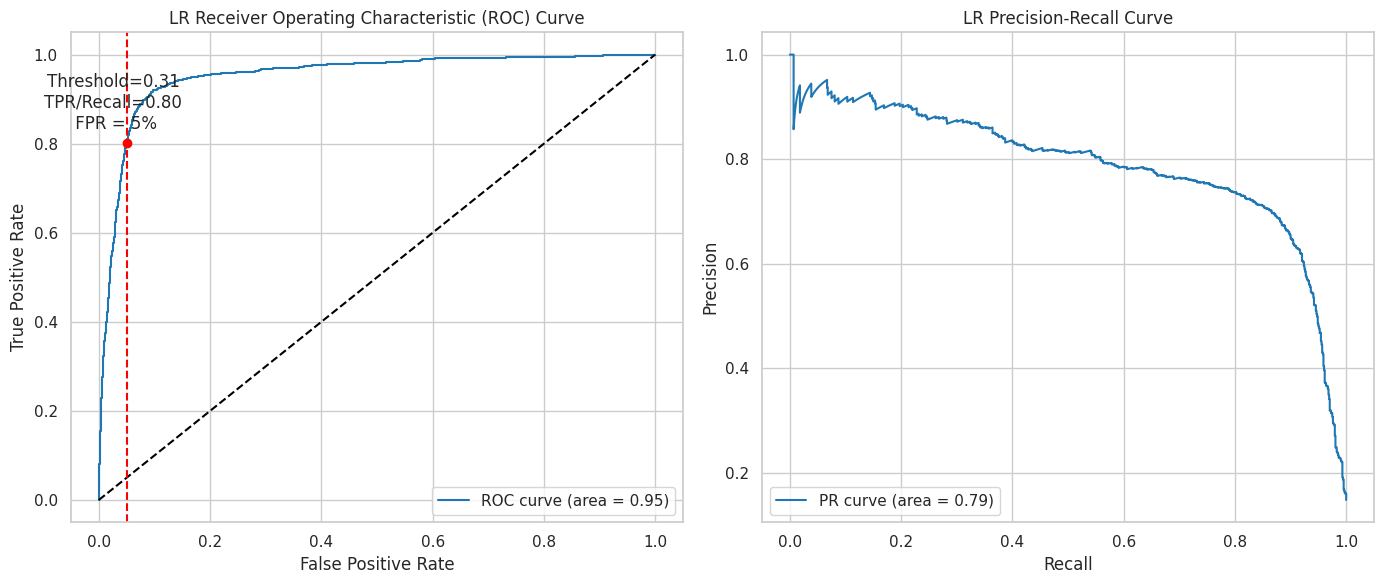

In [ ]:
# Assuming calculations for fpr, tpr, and thresholds_roc are already done

plt.figure(figsize=(14, 6))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlight the 5% FPR with a vertical line
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index for FPR just over 5%
plt.axvline(x=fpr[idx], color='r', linestyle='--')  # Vertical line for ~5% FPR
plt.plot(fpr[idx], tpr[idx], 'ro')  # Red dot at the intersection

# Adding a text annotation for the threshold
plt.annotate(f'Threshold={thresholds_roc[idx]:.2f}\nTPR/Recall={tpr[idx]:.2f}\n FPR = 5%', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('LR Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

## Random Forest

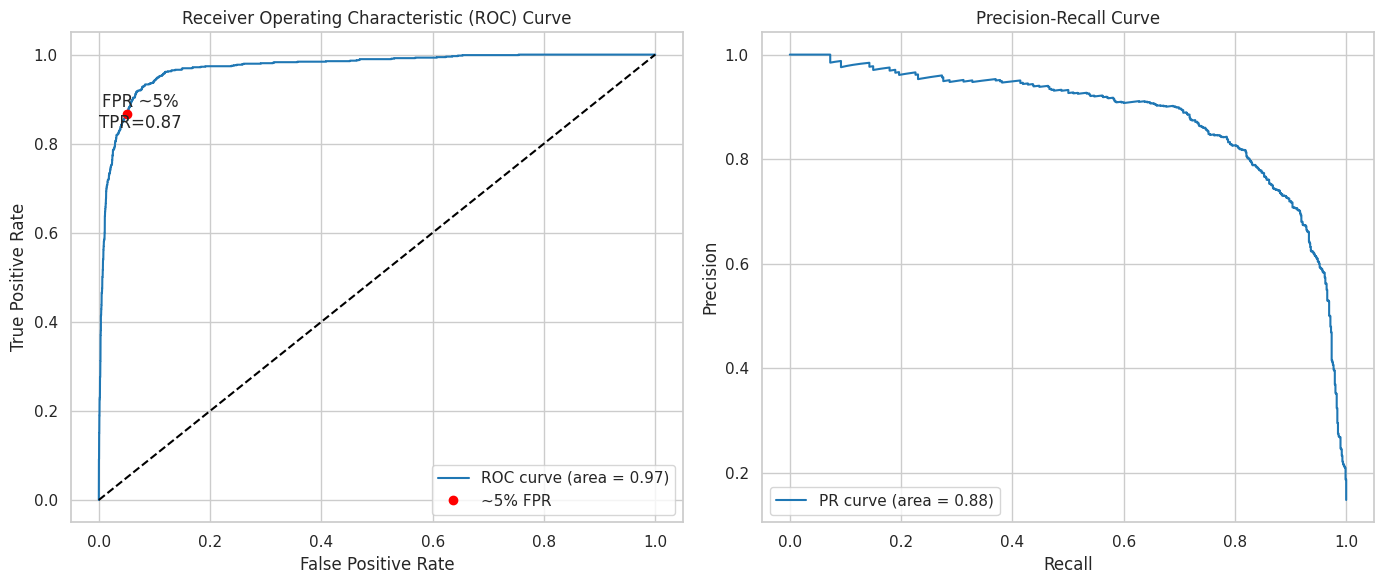

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_test_prob)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlighting the 5% FPR point
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index of the FPR just over 5%
plt.plot(fpr[idx], tpr[idx], 'ro', label='~5% FPR')  # 'ro' for red dot
plt.annotate(f'FPR ~5%\nTPR={tpr[idx]:.2f}', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

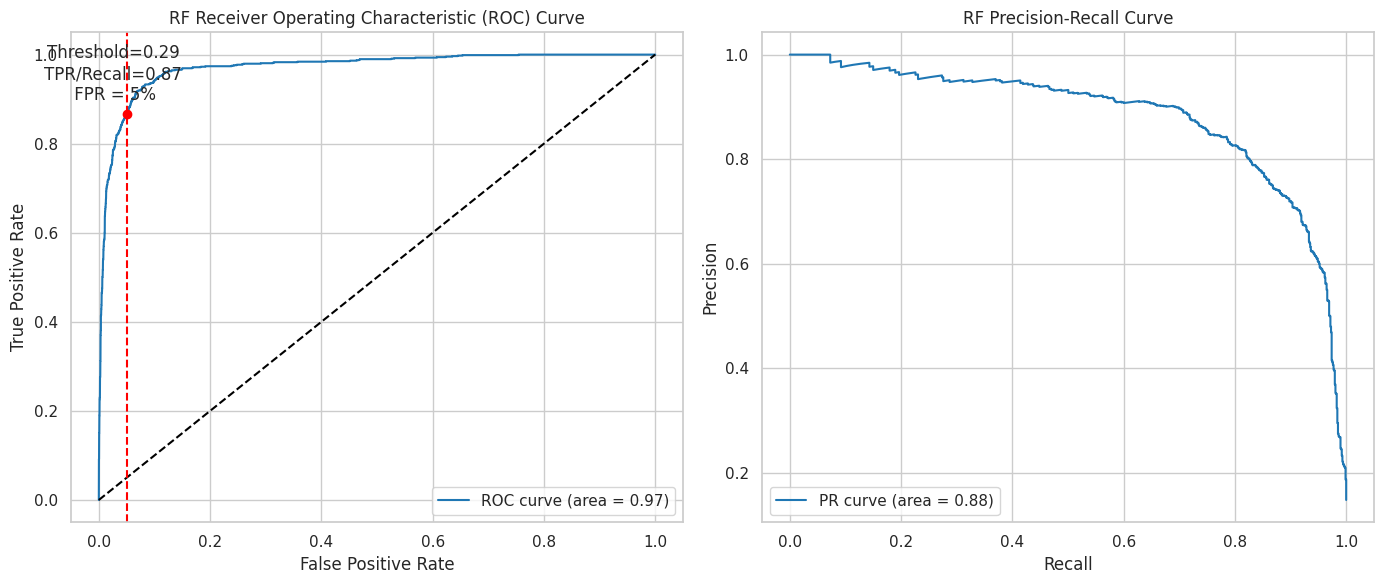

In [ ]:
# Assuming calculations for fpr, tpr, and thresholds_roc are already done

plt.figure(figsize=(14, 6))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlight the 5% FPR with a vertical line
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index for FPR just over 5%
plt.axvline(x=fpr[idx], color='r', linestyle='--')  # Vertical line for ~5% FPR
plt.plot(fpr[idx], tpr[idx], 'ro')  # Red dot at the intersection

# Adding a text annotation for the threshold
plt.annotate(f'Threshold={thresholds_roc[idx]:.2f}\nTPR/Recall={tpr[idx]:.2f}\n FPR = 5%', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('RF Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

## GBM

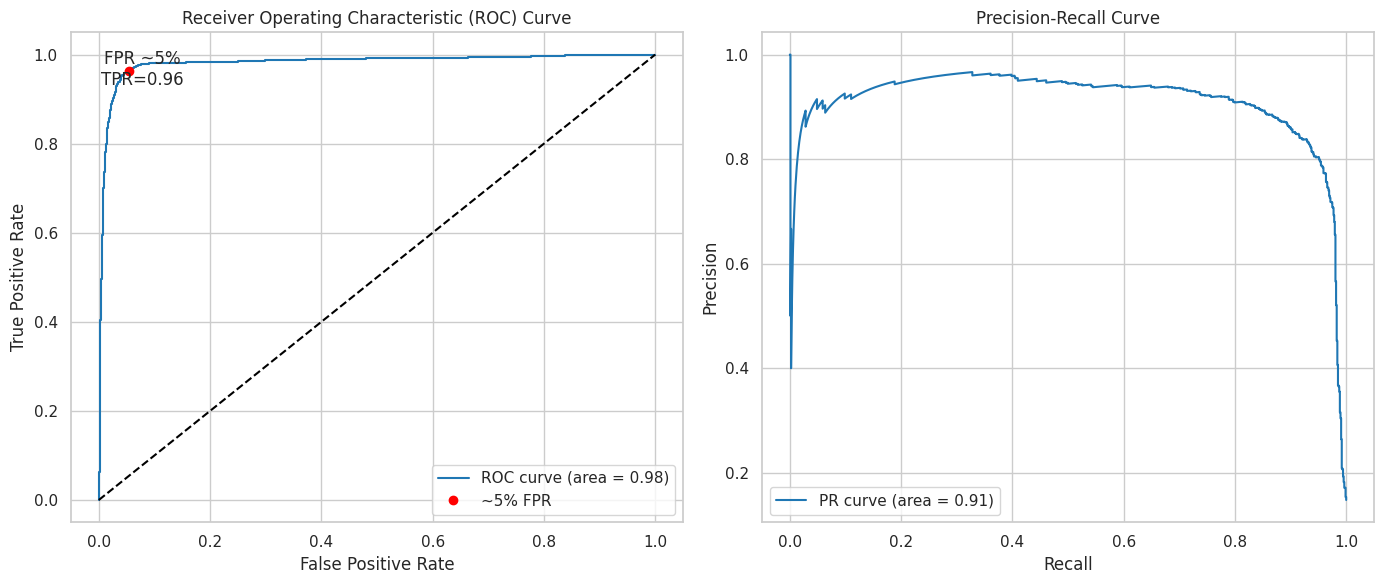

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_test_prob)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlighting the 5% FPR point
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index of the FPR just over 5%
plt.plot(fpr[idx], tpr[idx], 'ro', label='~5% FPR')  # 'ro' for red dot
plt.annotate(f'FPR ~5%\nTPR={tpr[idx]:.2f}', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

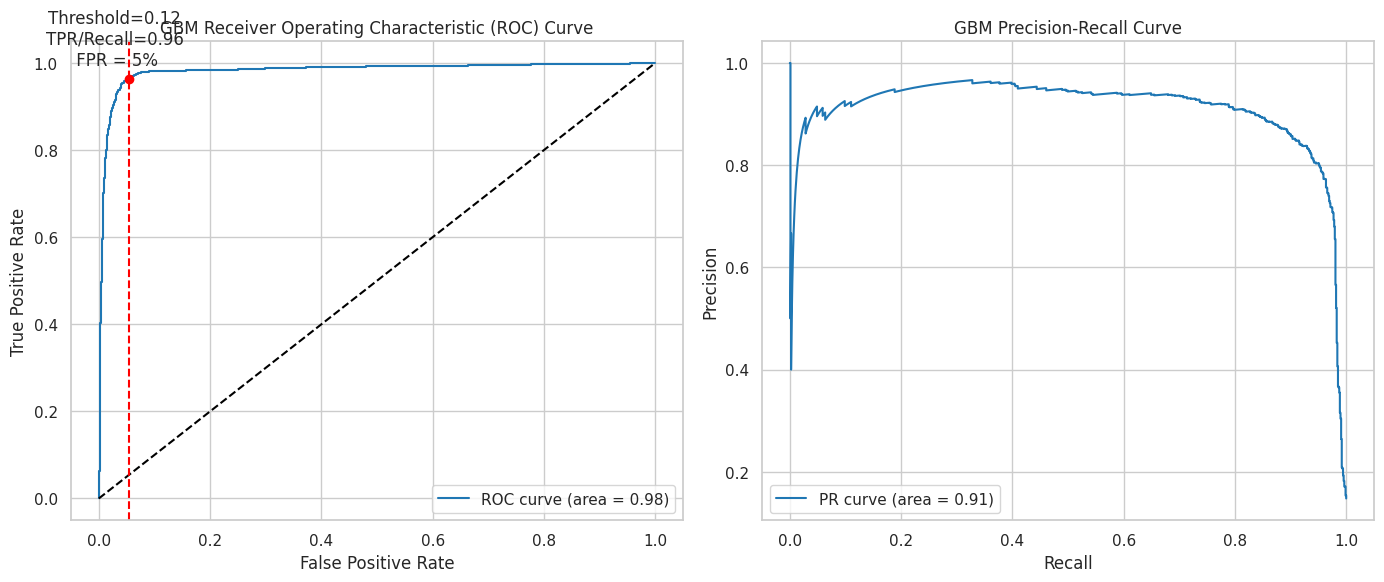

In [ ]:
# Assuming calculations for fpr, tpr, and thresholds_roc are already done

plt.figure(figsize=(14, 6))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlight the 5% FPR with a vertical line
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index for FPR just over 5%
plt.axvline(x=fpr[idx], color='r', linestyle='--')  # Vertical line for ~5% FPR
plt.plot(fpr[idx], tpr[idx], 'ro')  # Red dot at the intersection

# Adding a text annotation for the threshold
plt.annotate(f'Threshold={thresholds_roc[idx]:.2f}\nTPR/Recall={tpr[idx]:.2f}\n FPR = 5%', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GBM Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('GBM Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

## Stacking Classifier

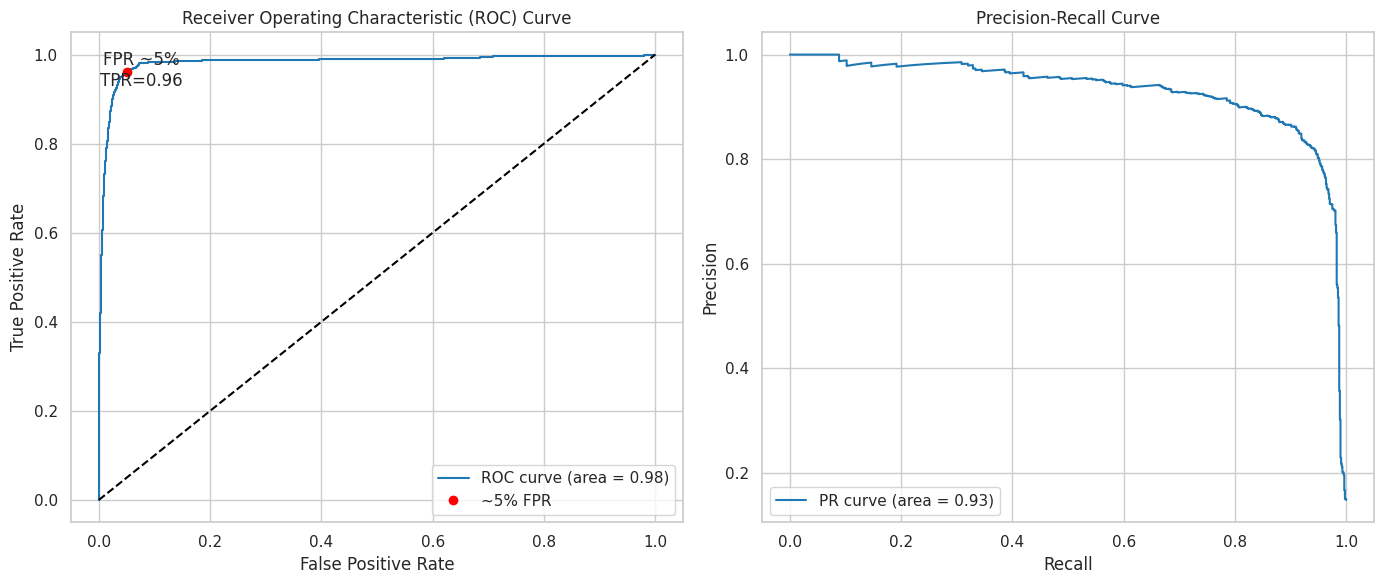

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_test_prob)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlighting the 5% FPR point
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index of the FPR just over 5%
plt.plot(fpr[idx], tpr[idx], 'ro', label='~5% FPR')  # 'ro' for red dot
plt.annotate(f'FPR ~5%\nTPR={tpr[idx]:.2f}', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


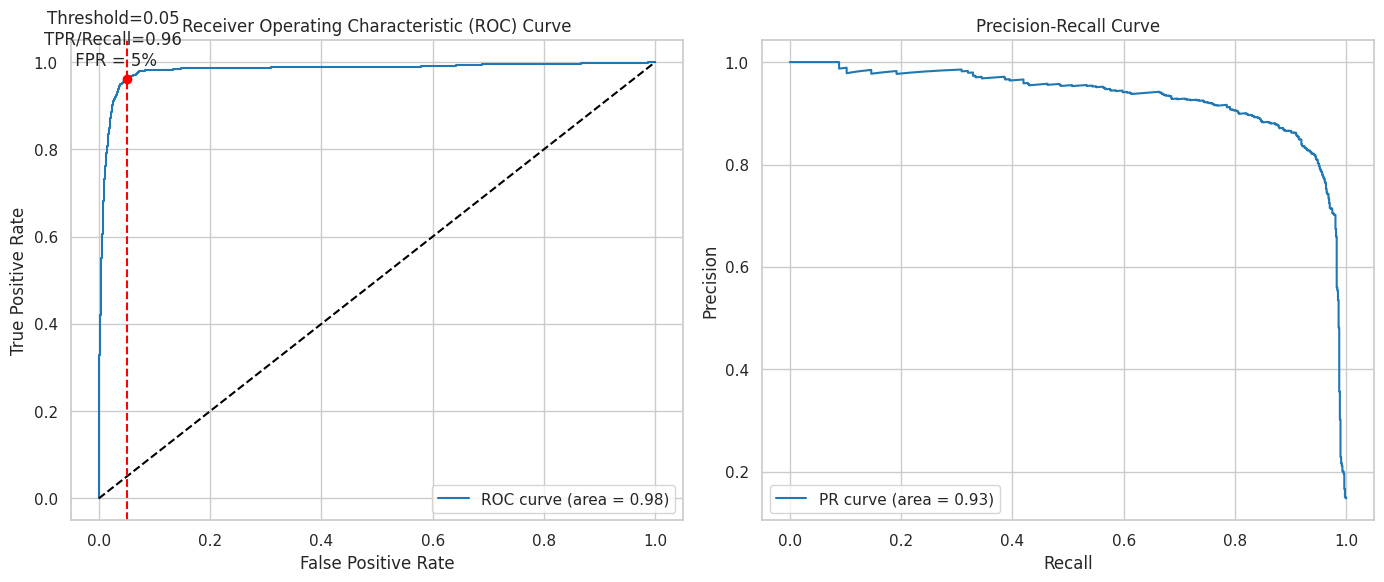

In [ ]:
plt.figure(figsize=(14, 6))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlight the 5% FPR with a vertical line
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index for FPR just over 5%
plt.axvline(x=fpr[idx], color='r', linestyle='--')  # Vertical line for ~5% FPR
plt.plot(fpr[idx], tpr[idx], 'ro')  # Red dot at the intersection

# Adding a text annotation for the threshold
plt.annotate(f'Threshold={thresholds_roc[idx]:.2f}\nTPR/Recall={tpr[idx]:.2f}\n FPR = 5%', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

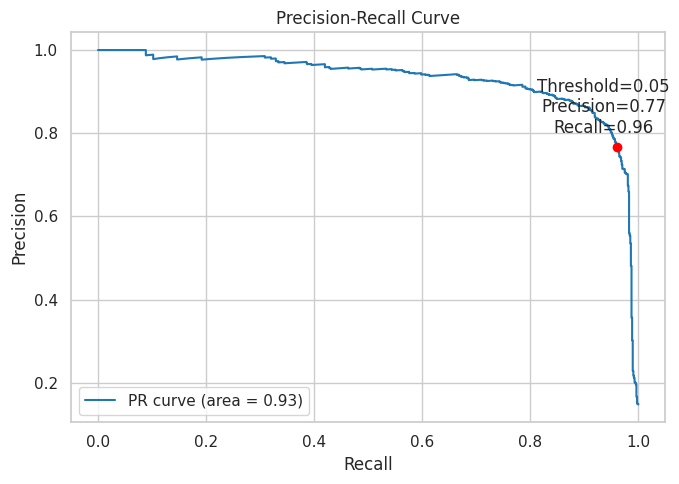

In [ ]:
# Find the closest threshold in the PR curve to the one identified in the ROC curve analysis
# This might not be exact due to the different metrics, but we find the nearest one
roc_threshold = thresholds_roc[idx]
closest_threshold_index = np.argmin(np.abs(thresholds_pr - roc_threshold))
selected_precision = precision[closest_threshold_index]
selected_recall = recall[closest_threshold_index]

plt.figure(figsize=(7, 5))

# Plot PR Curve
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Highlight the selected threshold
plt.plot(selected_recall, selected_precision, 'ro')  # Red dot at the selected threshold
plt.annotate(f'Threshold={roc_threshold:.2f}\nPrecision={selected_precision:.2f}\nRecall={selected_recall:.2f}',
             (selected_recall, selected_precision),
             textcoords="offset points",
             xytext=(-10,10),
             ha='center')

plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

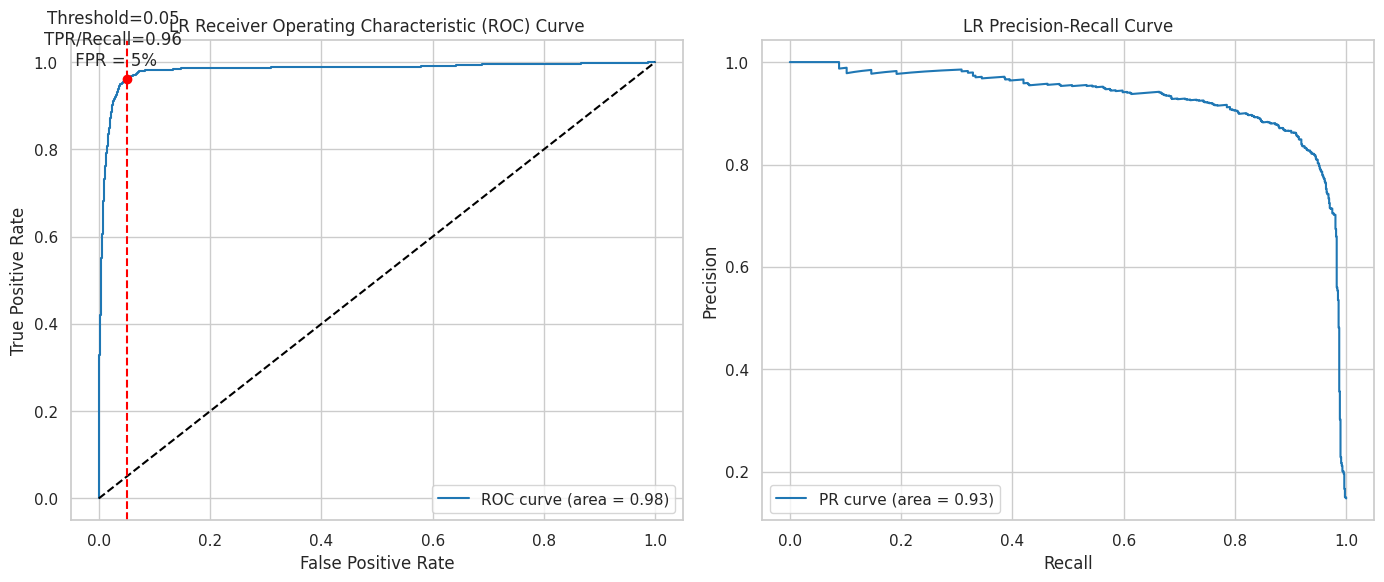

In [ ]:
# Assuming calculations for fpr, tpr, and thresholds_roc are already done

plt.figure(figsize=(14, 6))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

# Highlight the 5% FPR with a vertical line
idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index for FPR just over 5%
plt.axvline(x=fpr[idx], color='r', linestyle='--')  # Vertical line for ~5% FPR
plt.plot(fpr[idx], tpr[idx], 'ro')  # Red dot at the intersection

# Adding a text annotation for the threshold
plt.annotate(f'Threshold={thresholds_roc[idx]:.2f}\nTPR/Recall={tpr[idx]:.2f}\n FPR = 5%', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('LR Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Partial Dependence Plots

In [ ]:
numeric_features

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_rec_late_fee',
 'last_pymnt_amnt']

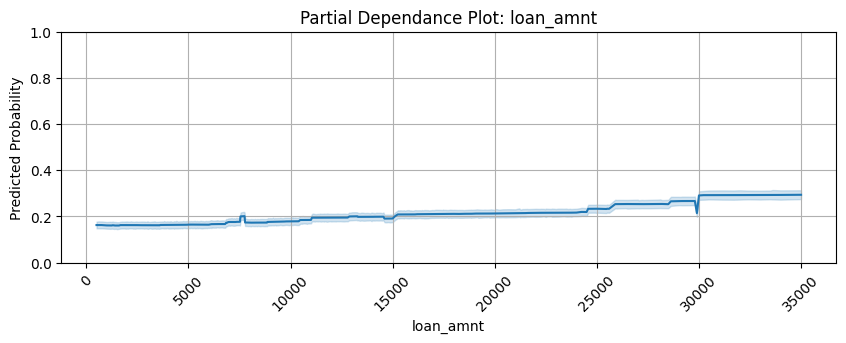

In [ ]:
var = 'loan_amnt'
sample_n = 1000
pdp_values = pd.DataFrame(X_train[var].sort_values().sample(frac=0.2).unique(),columns=[var])
pdp_sample = X_train.sample(sample_n).drop(var, axis=1)

pdp_cross = pdp_sample.merge(pdp_values, how='cross')
pdp_cross['pred'] = pipeline.predict_proba(pdp_cross)[:,1]
plt.figure(figsize=(10, 3))
sns.lineplot(x=f"{var}", y='pred', data=pdp_cross)
plt.title(f"Partial Dependance Plot: {var}")
plt.ylabel('Predicted Probability')
plt.xticks(rotation=45)
plt.ylim(0.0, 1)
plt.grid(True)
plt.show()

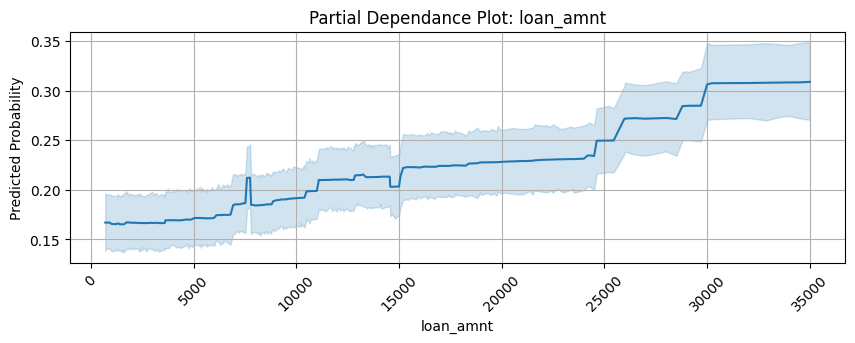

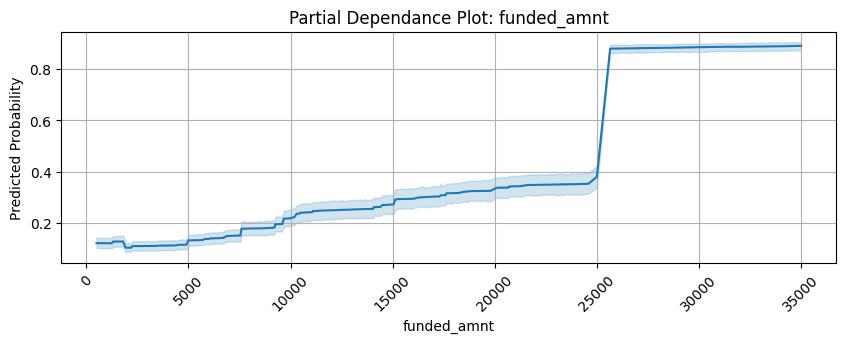

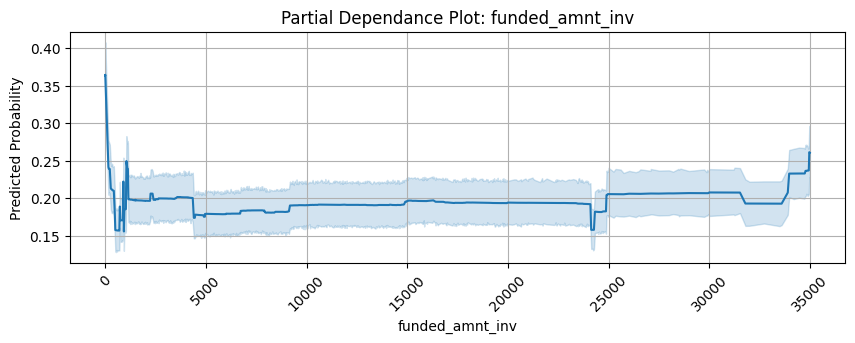

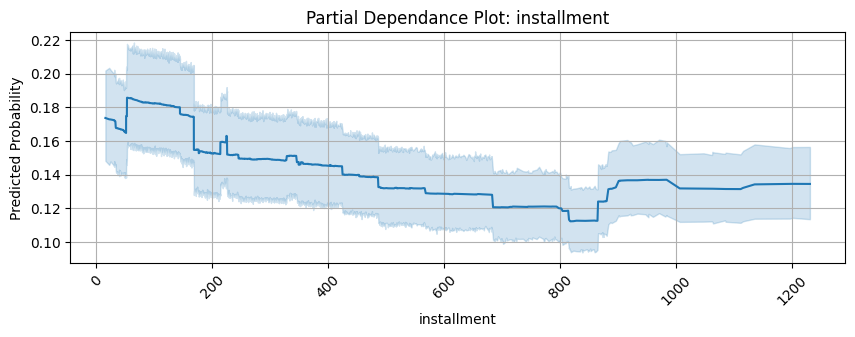

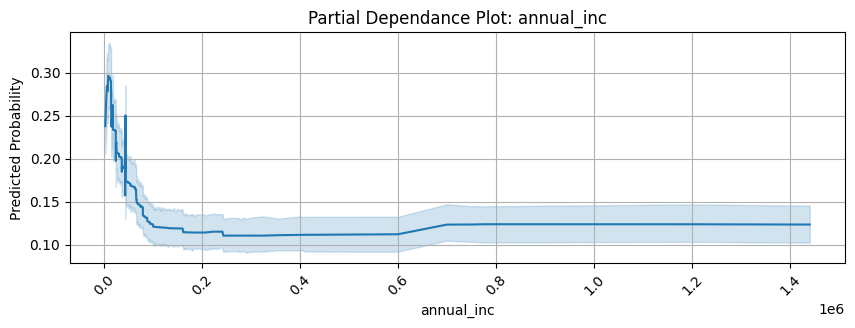

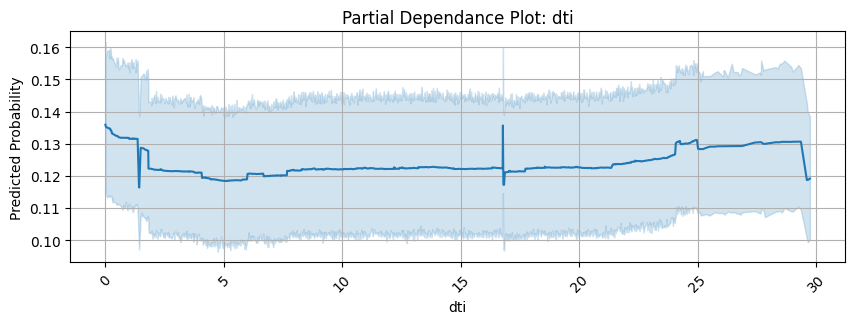

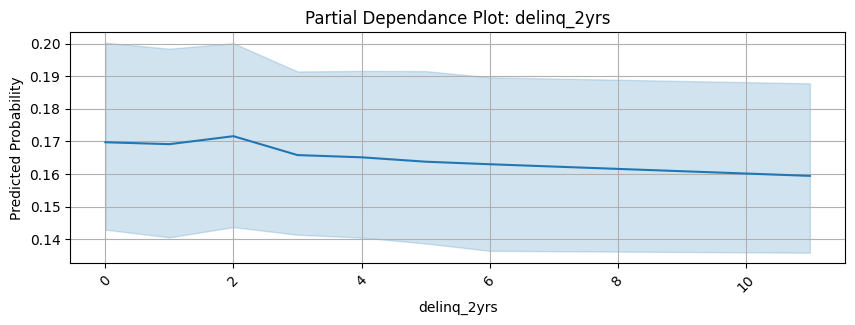

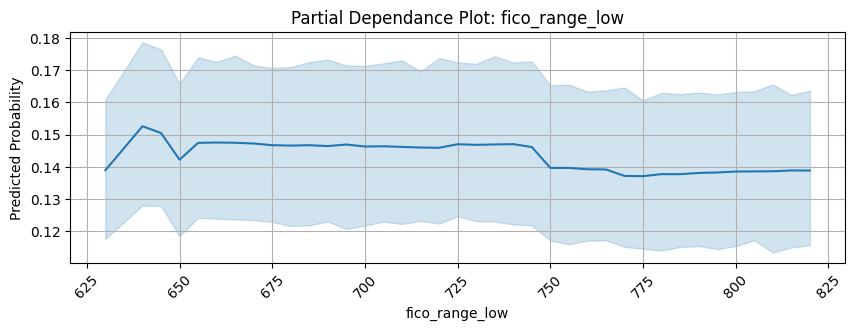

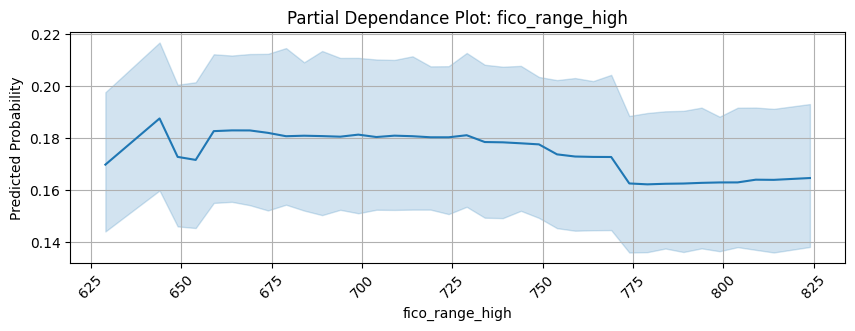

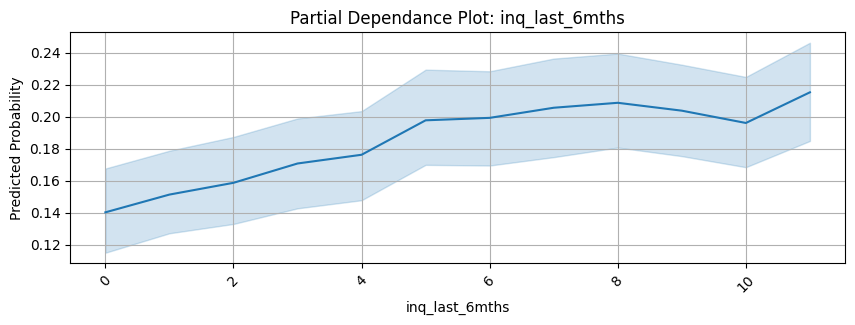

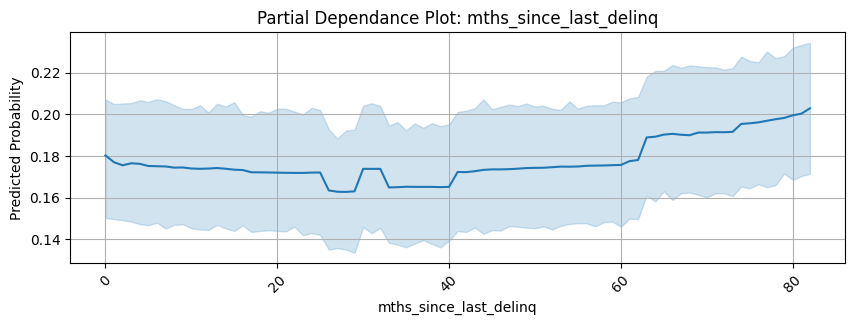

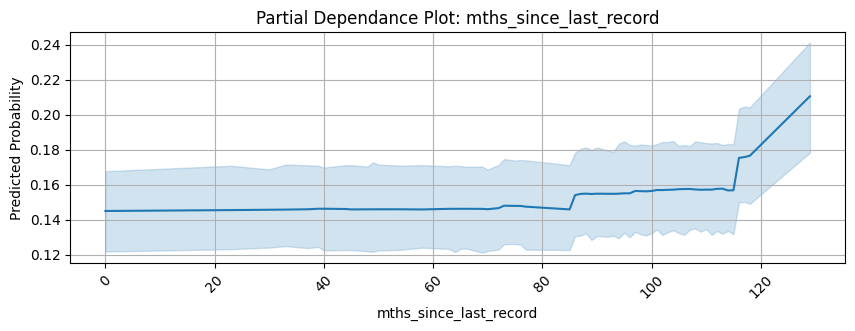

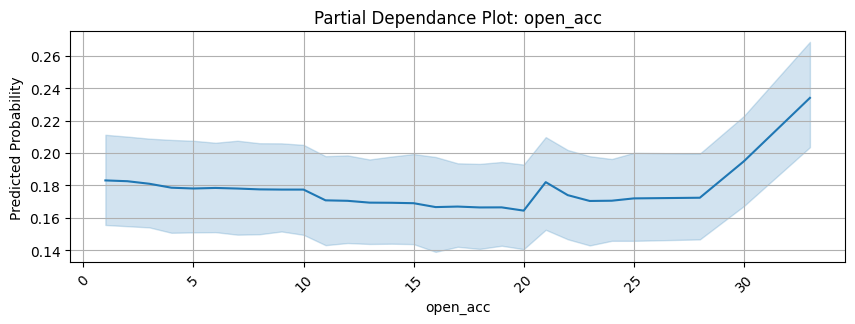

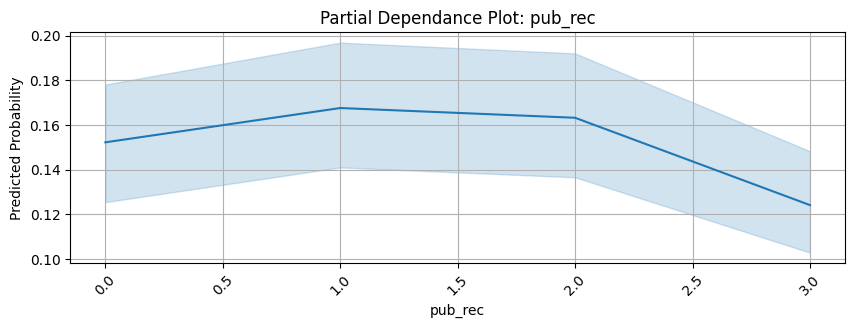

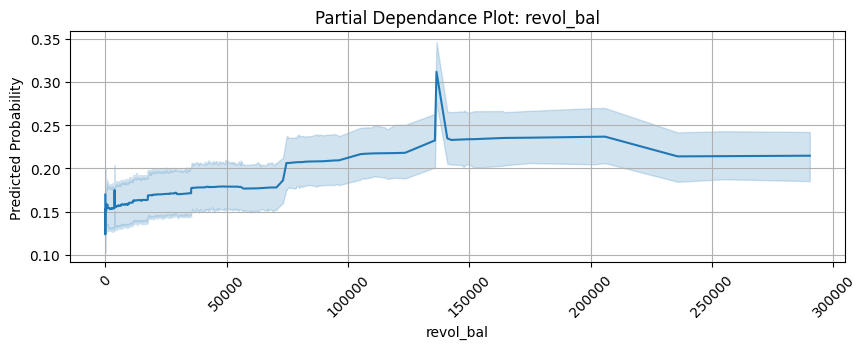

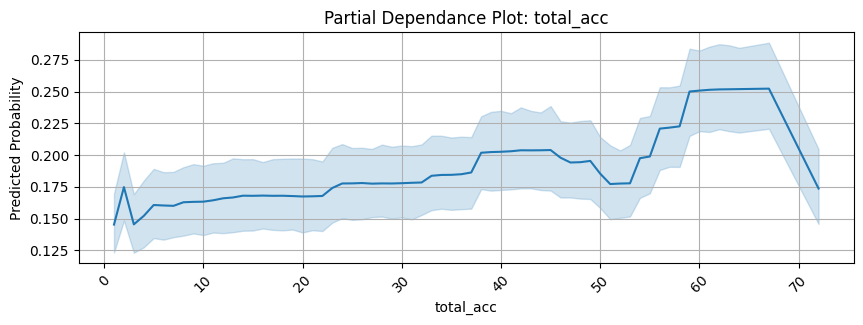

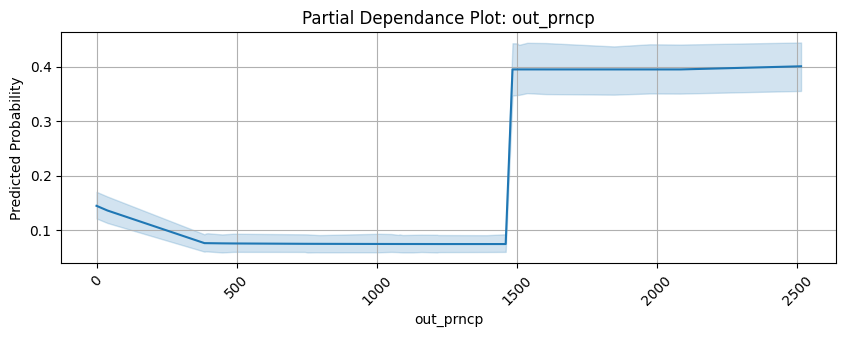

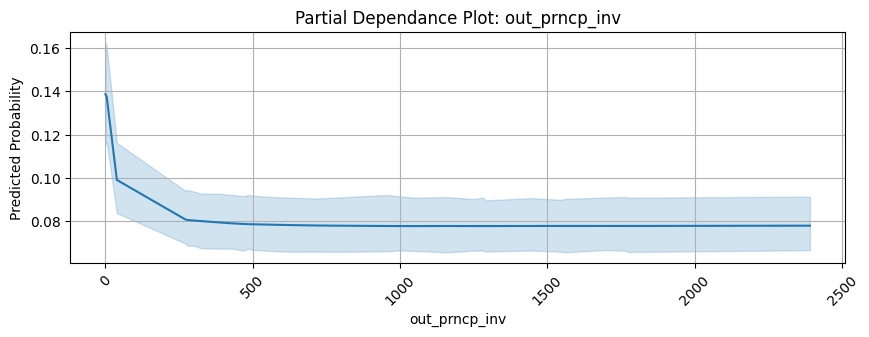

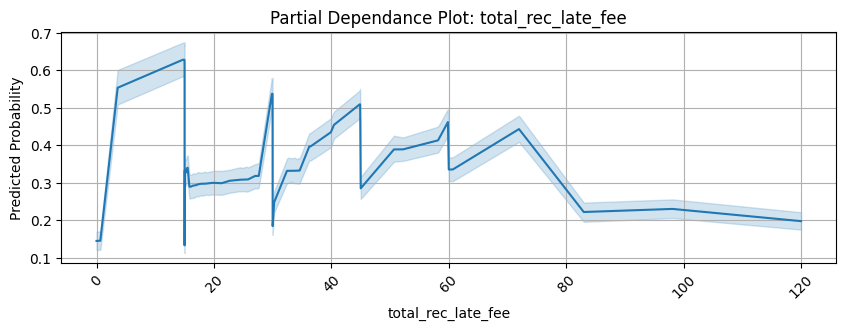

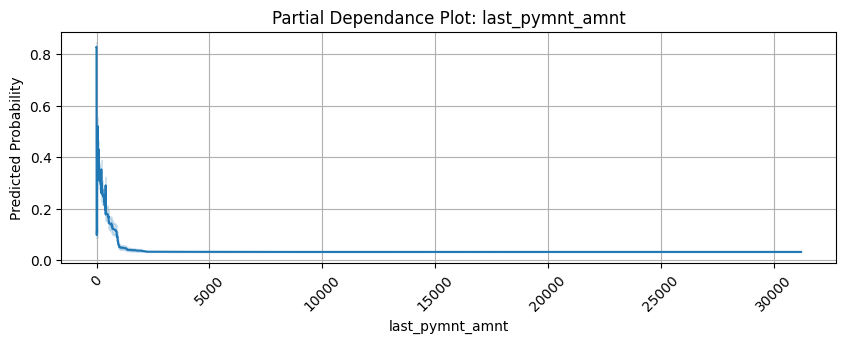

In [ ]:
def pdp_plot_numeric(var, sample_n):
  # var = 'credit_amount'
  pdp_values = pd.DataFrame(X_train[var].sort_values().sample(frac=0.1).unique(),columns=[var])
  pdp_sample = X_train.sample(sample_n).drop(var, axis=1)

  pdp_cross = pdp_sample.merge(pdp_values, how='cross')
  pdp_cross['pred'] = pipeline.predict_proba(pdp_cross)[:,1]
  plt.figure(figsize=(10, 3))
  sns.lineplot(x=f"{var}", y='pred', data=pdp_cross)
  plt.title(f"Partial Dependance Plot: {var}")
  plt.ylabel('Predicted Probability')
  plt.xticks(rotation=45)
  #plt.ylim(0, 1)
  plt.grid(True)
  plt.show()

# numeric_features = ['credit_amount', 'duration', 'age']
for var in numeric_features:
  pdp_plot_numeric(var, sample_n=300)

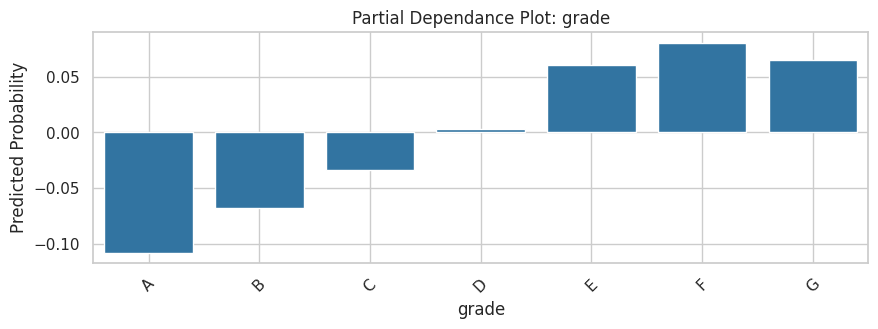

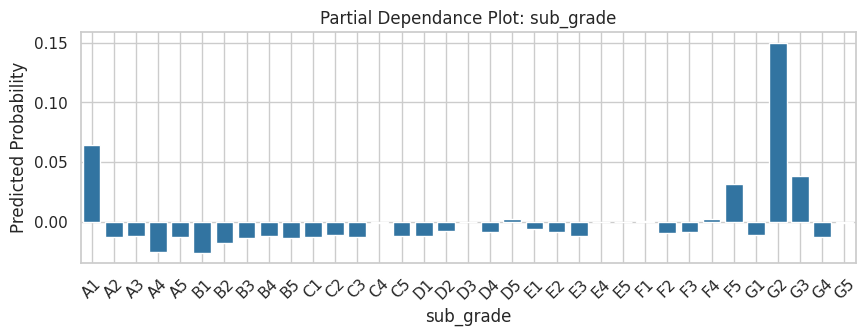

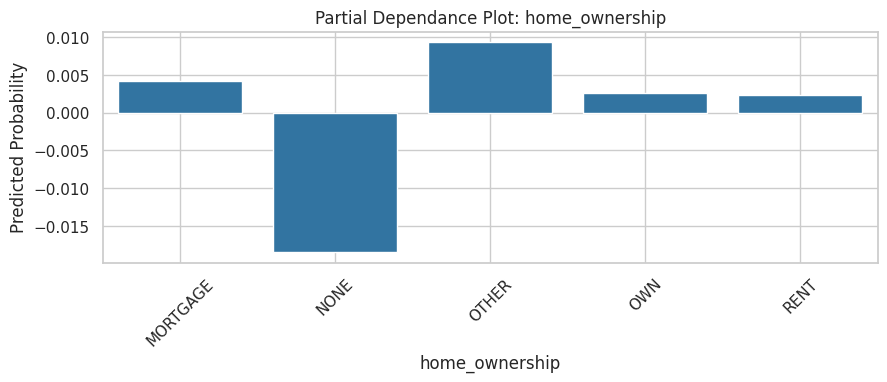

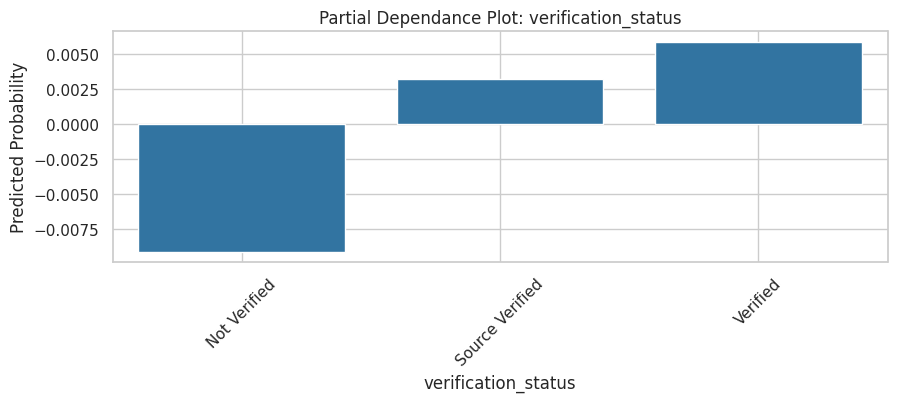

In [ ]:
def pdp_plot_categorical(var, sample_n):
  sns.set_style("whitegrid")  # Try "darkgrid", "ticks", etc.
  sns.set_context("notebook")  # Try "paper", "notebook", "poster" for different sizes

  pdp_values = pd.DataFrame(X_test[var].sort_values().unique(),columns=[var])
  pdp_sample = X_test.sample(sample_n).drop(var, axis=1)

  pdp_cross = pdp_sample.merge(pdp_values, how='cross')
  pdp_cross['pred'] = pipeline.predict_proba(pdp_cross)[:,1]
  mean_pred = pdp_cross['pred'].mean()
  pdp_cross['pred'] = pdp_cross['pred'].apply(lambda x: x - mean_pred)
  plt.figure(figsize=(10, 3))
 #sns.lineplot(x=f"{var}", y='pred', data=pdp_cross)
  sns.barplot(x=f"{var}", y='pred',
              ci=None,
              data=pdp_cross,
              estimator="mean")
  plt.title(f"Partial Dependance Plot: {var}")
  plt.ylabel('Predicted Probability')
  plt.xticks(rotation=45)
  #plt.ylim(0, 1)
  plt.grid(True)
  plt.show()


for var in categorical_features:
  pdp_plot_categorical(var, sample_n=100)

# Local Explanations

In [ ]:
pipeline_explainer = dx.Explainer(pipeline, X_test, y_test)
pipeline_explainer

Preparation of a new explainer is initiated

  -> data              : 5956 rows 24 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 5956 values
  -> model_class       : sklearn.ensemble._stacking.StackingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7e52e4c391b0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0283, mean = 0.149, max = 0.978
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.959, mean = -0.00114, max = 0.971
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
X_test['pred']= pipeline.predict(X_test)
X_test['pred_proba']= pipeline.predict_proba(X_test)[:,1]
X_test[target] = y_test
X_test.head()

loan_amnt  funded_amnt  funded_amnt_inv  installment  annual_inc  \
13494     4375.0       4375.0      4225.000000       131.95     17760.0   
21759    10000.0      10000.0      9475.000000       323.85     55000.0   
11247    24000.0      24000.0     22921.129991       560.56     53000.0   
25028     5550.0       5550.0      5550.000000       189.98     50000.0   
20440    10000.0      10000.0      9875.000000       232.58     45000.0   

         dti  delinq_2yrs  fico_range_low  fico_range_high  inq_last_6mths  \
13494  20.20          0.0           750.0            754.0             0.0   
21759  18.59          0.0           715.0            719.0             0.0   
11247  22.42          0.0           740.0            744.0             1.0   
25028  21.58          0.0           665.0            669.0             2.0   
20440   5.97          0.0           765.0            769.0             0.0   

       ...  out_prncp_inv  total_rec_late_fee  last_pymnt_amnt  grade  \
13494  ...            0.0                 0.0            36.57      A   
21759  ...            0.0                 0.0          1317.62      B   
11247  ...            0.0                 0.0         23722.52      C   
25028  ...            0.0                 0.0           202.16      D   
20440  ...            0.0                 0.0           232.58      C   

       sub_grade  home_ownership  verification_status  pred  pred_proba  \
13494         A1             OWN      Source Verified     0    0.105111   
21759         B2            RENT         Not Verified     0    0.029127   
11247         C5        MORTGAGE             Verified     0    0.031777   
25028         D1        MORTGAGE         Not Verified     0    0.308618   
20440         C3            RENT         Not Verified     0    0.151701   

       loan_status  
13494            0  
21759            0  
11247            0  
25028            0  
20440            1  

[5 rows x 27 columns]

## Top 10 TP

In [ ]:
top_10_tp = (X_test
             .query('pred == 1 and loan_status == 1')
             .sort_values(by='pred_proba', ascending=False)
             .head(10)
             .reset_index(drop=True)
)
top_10_tp

loan_amnt  funded_amnt  funded_amnt_inv  installment  annual_inc    dti  \
0     8000.0       8000.0      7975.000000       201.03     40000.0  14.07   
1     3500.0       3500.0      3497.735264       120.00     18000.0   7.80   
2     4500.0       4500.0      4500.000000       157.44     21600.0  10.83   
3     2400.0       2400.0      2400.000000        60.86     21600.0   6.00   
4    12000.0      12000.0     12000.000000       287.25     60000.0  24.02   
5    30000.0      30000.0      7100.000000       778.72     51600.0  19.09   
6     6000.0       6000.0      5925.000000       199.89     26400.0  11.05   
7     4000.0       4000.0      3975.000000        97.17     26400.0   3.77   
8    18000.0      18000.0     12450.000005       494.49     36000.0  11.27   
9     3000.0       3000.0      3000.000000        93.85     28800.0  20.33   

   delinq_2yrs  fico_range_low  fico_range_high  inq_last_6mths  ...  \
0          0.0           675.0            679.0             2.0  ...   
1          2.0           665.0            669.0             2.0  ...   
2          0.0           670.0            674.0             0.0  ...   
3          1.0           675.0            679.0             2.0  ...   
4          3.0           680.0            684.0             2.0  ...   
5          0.0           705.0            709.0             3.0  ...   
6          0.0           685.0            689.0             0.0  ...   
7          1.0           685.0            689.0             0.0  ...   
8          0.0           660.0            664.0             2.0  ...   
9          0.0           715.0            719.0             3.0  ...   

   out_prncp_inv  total_rec_late_fee  last_pymnt_amnt  grade  sub_grade  \
0            0.0           14.932100           201.03      E         E4   
1            0.0           14.943750           120.00      C         C5   
2            0.0           14.987723           157.44      D         D4   
3            0.0           14.953171            60.86      E         E5   
4            0.0           14.908094           103.98      D         D3   
5            0.0            0.000000             0.00      E         E2   
6            0.0           14.951804           200.49      B         B5   
7            0.0           14.896573            97.17      D         D4   
8            0.0            0.000000             0.03      F         F5   
9            0.0           14.971231           108.85      A         A5   

   home_ownership  verification_status  pred  pred_proba  loan_status  
0            RENT      Source Verified     1    0.978245            1  
1             OWN         Not Verified     1    0.974025            1  
2            RENT      Source Verified     1    0.973707            1  
3             OWN             Verified     1    0.972843            1  
4        MORTGAGE         Not Verified     1    0.969567            1  
5        MORTGAGE             Verified     1    0.968747            1  
6        MORTGAGE         Not Verified     1    0.967491            1  
7            RENT      Source Verified     1    0.966918            1  
8            RENT             Verified     1    0.966395            1  
9            RENT         Not Verified     1    0.965896            1  

[10 rows x 27 columns]

### Breakdown Plot

In [ ]:
bd_1 = pipeline_explainer.predict_parts(top_10_tp.iloc[0],
                                           type='break_down',
                                           label="record 1")

In [ ]:
bd_1.result

variable_name   variable_value  \
0                intercept                    
1       total_rec_late_fee            14.93   
2          last_pymnt_amnt            201.0   
3                    grade                E   
4               annual_inc          40000.0   
5                loan_amnt           8000.0   
6              funded_amnt           8000.0   
7                sub_grade               E4   
8          funded_amnt_inv           7975.0   
9           inq_last_6mths              2.0   
10             installment            201.0   
11     verification_status  Source Verified   
12          fico_range_low            675.0   
13                open_acc              5.0   
14         fico_range_high            679.0   
15               out_prncp              0.0   
16           out_prncp_inv              0.0   
17                     dti            14.07   
18             delinq_2yrs              0.0   
19             loan_status              1.0   
20              pred_proba           0.9782   
21                    pred              1.0   
22  mths_since_last_delinq              nan   
23  mths_since_last_record              nan   
24          home_ownership             RENT   
25               revol_bal           6868.0   
26                 pub_rec              0.0   
27               total_acc             11.0   
28                                            

                                 variable  cumulative  contribution  sign  \
0                               intercept    0.149061      0.149061   1.0   
1              total_rec_late_fee = 14.93    0.599382      0.450321   1.0   
2                 last_pymnt_amnt = 201.0    0.939823      0.340441   1.0   
3                               grade = E    0.952141      0.012318   1.0   
4                    annual_inc = 40000.0    0.958123      0.005982   1.0   
5                      loan_amnt = 8000.0    0.958304      0.000181   1.0   
6                    funded_amnt = 8000.0    0.955976     -0.002327  -1.0   
7                          sub_grade = E4    0.958275      0.002298   1.0   
8                funded_amnt_inv = 7975.0    0.959587      0.001312   1.0   
9                    inq_last_6mths = 2.0    0.960376      0.000789   1.0   
10                    installment = 201.0    0.965738      0.005362   1.0   
11  verification_status = Source Verified    0.966291      0.000554   1.0   
12                 fico_range_low = 675.0    0.968632      0.002341   1.0   
13                         open_acc = 5.0    0.968688      0.000055   1.0   
14                fico_range_high = 679.0    0.969196      0.000508   1.0   
15                        out_prncp = 0.0    0.975774      0.006578   1.0   
16                    out_prncp_inv = 0.0    0.976275      0.000501   1.0   
17                            dti = 14.07    0.977435      0.001160   1.0   
18                      delinq_2yrs = 0.0    0.977851      0.000415   1.0   
19                      loan_status = 1.0    0.977851      0.000000   0.0   
20                    pred_proba = 0.9782    0.977851      0.000000   0.0   
21                             pred = 1.0    0.977851      0.000000   0.0   
22           mths_since_last_delinq = nan    0.978273      0.000422   1.0   
23           mths_since_last_record = nan    0.978367      0.000094   1.0   
24                  home_ownership = RENT    0.978611      0.000244   1.0   
25                     revol_bal = 6868.0    0.978576     -0.000035  -1.0   
26                          pub_rec = 0.0    0.978703      0.000127   1.0   
27                       total_acc = 11.0    0.978245     -0.000458  -1.0   
28                             prediction    0.978245      0.978245   1.0   

    position     label  
0         28  record 1  
1         27  record 1  
2         26  record 1  
3         25  record 1  
4         24  record 1  
5         23  record 1  
6         22  record 1  
7         21  record 1  
8         20  record 1  
9         19  record 1  
10        18  re

In [ ]:
bd_1.plot()

### Local Breakdown Plots

In [ ]:
for index, row in top_10_tp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_tp.iloc[index],
      type='break_down',
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

### Shapley Explanations

In [ ]:
for index, row in top_10_tp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_tp.iloc[index],
      type='shap',
      B=5,
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

## Top 10 FP

In [ ]:
top_10_fp = (X_test
             .query('pred == 1 and loan_status == 0')
             .sort_values(by='pred_proba', ascending=True)
             .head(10)
             .reset_index(drop=True)
)
top_10_fp

### Breakdown Plot

In [ ]:
bd_2 = pipeline_explainer.predict_parts(top_10_fp.iloc[0],
                                           type='break_down',
                                           label="record 1")

In [ ]:
bd_2.result

variable_name   variable_value  \
0                intercept                    
1          last_pymnt_amnt            94.34   
2              funded_amnt          20000.0   
3       total_rec_late_fee            26.97   
4                    grade                G   
5                loan_amnt          20000.0   
6                sub_grade               G3   
7          funded_amnt_inv          19910.0   
8               annual_inc          60000.0   
9      verification_status  Source Verified   
10                open_acc              4.0   
11          fico_range_low            675.0   
12         fico_range_high            679.0   
13               revol_bal          13490.0   
14               out_prncp              0.0   
15          home_ownership         MORTGAGE   
16           out_prncp_inv              0.0   
17             loan_status              0.0   
18              pred_proba           0.9593   
19                    pred              1.0   
20             delinq_2yrs              1.0   
21  mths_since_last_record              nan   
22  mths_since_last_delinq             10.0   
23                 pub_rec              0.0   
24                     dti             6.44   
25               total_acc             16.0   
26          inq_last_6mths              0.0   
27             installment            539.4   
28                                            

                                 variable  cumulative  contribution  sign  \
0                               intercept    0.149061      0.149061   1.0   
1                 last_pymnt_amnt = 94.34    0.382302      0.233242   1.0   
2                   funded_amnt = 20000.0    0.658437      0.276134   1.0   
3              total_rec_late_fee = 26.97    0.839111      0.180674   1.0   
4                               grade = G    0.903328      0.064217   1.0   
5                     loan_amnt = 20000.0    0.912230      0.008902   1.0   
6                          sub_grade = G3    0.936391      0.024160   1.0   
7               funded_amnt_inv = 19910.0    0.941142      0.004751   1.0   
8                    annual_inc = 60000.0    0.948396      0.007254   1.0   
9   verification_status = Source Verified    0.950369      0.001973   1.0   
10                         open_acc = 4.0    0.950963      0.000594   1.0   
11                 fico_range_low = 675.0    0.954620      0.003657   1.0   
12                fico_range_high = 679.0    0.953693     -0.000927  -1.0   
13                    revol_bal = 13490.0    0.954678      0.000985   1.0   
14                        out_prncp = 0.0    0.959179      0.004501   1.0   
15              home_ownership = MORTGAGE    0.960142      0.000963   1.0   
16                    out_prncp_inv = 0.0    0.963186      0.003044   1.0   
17                      loan_status = 0.0    0.963186      0.000000   0.0   
18                    pred_proba = 0.9593    0.963186      0.000000   0.0   
19                             pred = 1.0    0.963186      0.000000   0.0   
20                      delinq_2yrs = 1.0    0.964301      0.001115   1.0   
21           mths_since_last_record = nan    0.964395      0.000093   1.0   
22          mths_since_last_delinq = 10.0    0.963553     -0.000842  -1.0   
23                          pub_rec = 0.0    0.963400     -0.000152  -1.0   
24                             dti = 6.44    0.963555      0.000155   1.0   
25                       total_acc = 16.0    0.962837     -0.000718  -1.0   
26                   inq_last_6mths = 0.0    0.960754     -0.002083  -1.0   
27                    installment = 539.4    0.959348     -0.001406  -1.0   
28                             prediction    0.959348      0.959348   1.0   

    position     label  
0         28  record 1  
1         27  record 1  
2         26  record 1  
3         25  record 1  
4         24  record 1  
5         23  record 1  
6         22  record 1  
7         21  record 1  
8         20  record 1  
9         19  record 1  
10        18  re

In [ ]:
bd_2.plot()

### Local Breakdown Plots

In [ ]:
for index, row in top_10_fp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_fp.iloc[index],
      type='break_down',
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

### Shapley Explanations

In [ ]:
for index, row in top_10_fp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_fp.iloc[index],
      type='shap',
      B=5,
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

## Top 10 FN

In [ ]:
top_10_fn = (X_test
             .query('pred == 0 and loan_status == 1')
             .sort_values(by='pred_proba', ascending=True)
             .head(10)
             .reset_index(drop=True)
)
top_10_fn

loan_amnt  funded_amnt  funded_amnt_inv  installment  annual_inc    dti  \
0     5000.0       5000.0      5000.000000       164.86     37000.0  19.20   
1     7000.0       7000.0      7000.000000       212.29     46932.0  26.00   
2    20000.0      20000.0     17991.544969       421.22     96000.0   0.99   
3    16000.0      16000.0     15900.000000       385.53     78000.0   8.57   
4     3600.0       3600.0      3600.000000        86.75     46000.0  19.57   
5    25000.0      15925.0     15850.000000       428.77    120000.0   9.50   
6    16000.0      16000.0      7185.610000       553.01    110000.0  23.78   
7    35000.0      35000.0     20775.004916       858.59    115000.0   6.47   
8    10000.0      10000.0      9925.000000       320.95     30000.0  15.88   
9     6000.0       6000.0      5950.000000       180.96     52800.0   5.73   

   delinq_2yrs  fico_range_low  fico_range_high  inq_last_6mths  ...  \
0          0.0           670.0            674.0             0.0  ...   
1          0.0           750.0            754.0             3.0  ...   
2          1.0           725.0            729.0             1.0  ...   
3          0.0           700.0            704.0             1.0  ...   
4          1.0           675.0            679.0             0.0  ...   
5          1.0           665.0            669.0             1.0  ...   
6          0.0           700.0            704.0             3.0  ...   
7          0.0           745.0            749.0             1.0  ...   
8          0.0           760.0            764.0             0.0  ...   
9          0.0           755.0            759.0             0.0  ...   

   out_prncp_inv  total_rec_late_fee  last_pymnt_amnt  grade  sub_grade  \
0            0.0                 0.0          1763.84      B         B4   
1            0.0                 0.0          2300.00      A         A2   
2            0.0                 0.0          4841.69      B         B3   
3            0.0                 0.0         10021.06      D         D3   
4            0.0                 0.0          1911.36      D         D3   
5            0.0                 0.0          8480.98      G         G4   
6            0.0                 0.0          1106.02      C         C4   
7            0.0                 0.0         11800.00      E         E1   
8            0.0                 0.0           431.76      A         A5   
9            0.0                 0.0           180.96      A         A1   

   home_ownership  verification_status  pred  pred_proba  loan_status  
0            RENT             Verified     0    0.028554            1  
1             OWN             Verified     0    0.028697            1  
2             OWN      Source Verified     0    0.029912            1  
3        MORTGAGE             Verified     0    0.030396            1  
4            RENT         Not Verified     0    0.030684            1  
5        MORTGAGE             Verified     0    0.034460            1  
6        MORTGAGE             Verified     0    0.034826            1  
7        MORTGAGE             Verified     0    0.037190            1  
8            RENT      Source Verified     0    0.038750            1  
9        MORTGAGE      Source Verified     0    0.038950            1  

[10 rows x 27 columns]

### Breakdown Plot

In [ ]:
bd_3 = pipeline_explainer.predict_parts(top_10_fn.iloc[0],
                                           type='break_down',
                                           label="record 1")

In [ ]:
bd_3.result

variable_name variable_value                        variable  \
0                intercept                                      intercept   
1              installment          164.9             installment = 164.9   
2               annual_inc        37000.0            annual_inc = 37000.0   
3                loan_amnt         5000.0              loan_amnt = 5000.0   
4          funded_amnt_inv         5000.0        funded_amnt_inv = 5000.0   
5      verification_status       Verified  verification_status = Verified   
6           fico_range_low          670.0          fico_range_low = 670.0   
7          fico_range_high          674.0         fico_range_high = 674.0   
8                 open_acc           10.0                 open_acc = 10.0   
9                out_prncp            0.0                 out_prncp = 0.0   
10           out_prncp_inv            0.0             out_prncp_inv = 0.0   
11                     dti           19.2                      dti = 19.2   
12             delinq_2yrs            0.0               delinq_2yrs = 0.0   
13              pred_proba        0.02855            pred_proba = 0.02855   
14             loan_status            1.0               loan_status = 1.0   
15                    pred            0.0                      pred = 0.0   
16               sub_grade             B4                  sub_grade = B4   
17  mths_since_last_delinq            nan    mths_since_last_delinq = nan   
18  mths_since_last_record            nan    mths_since_last_record = nan   
19          home_ownership           RENT           home_ownership = RENT   
20                 pub_rec            0.0                   pub_rec = 0.0   
21               revol_bal         5505.0              revol_bal = 5505.0   
22               total_acc           15.0                total_acc = 15.0   
23      total_rec_late_fee            0.0        total_rec_late_fee = 0.0   
24          inq_last_6mths            0.0            inq_last_6mths = 0.0   
25                   grade              B                       grade = B   
26             funded_amnt         5000.0            funded_amnt = 5000.0   
27         last_pymnt_amnt         1764.0        last_pymnt_amnt = 1764.0   
28                                                             prediction   

    cumulative  contribution  sign  position     label  
0     0.149061      0.149061   1.0        28  record 1  
1     0.176765      0.027704   1.0        27  record 1  
2     0.199882      0.023117   1.0        26  record 1  
3     0.210659      0.010778   1.0        25  record 1  
4     0.215787      0.005128   1.0        24  record 1  
5     0.222139      0.006352   1.0        23  record 1  
6     0.233338      0.011199   1.0        22  record 1  
7     0.236798      0.003460   1.0        21  record 1  
8     0.242639      0.005841   1.0        20  record 1  
9     0.245497      0.002858   1.0        19  record 1  
10    0.248862      0.003365   1.0        18  record 1  
11    0.250793      0.001931   1.0        17  record 1  
12    0.251356      0.000563   1.0        16  record 1  
13    0.251356      0.000000   0.0        15  record 1  
14    0.251356      0.000000   0.0        14  record 1  
15    0.251356      0.000000   0.0        13  record 1  
16    0.248739     -0.002617  -1.0        12  record 1  
17    0.248680     -0.000059  -1.0        11  record 1  
18    0.248063     -0.000618  -1.0        10  record 1  
19    0.244927     -0.003136  -1.0         9  record 1  
20    0.243444     -0.001484  -1.0         8  record 1  
21    0.228726     -0.014718  -1.0         7  record 1  
22    0.220251     -0.008475  -1.0         6  record 1  
23    0.209367     -0.010884  -1.0         5  record 1  
24    0.193897     -0.015470  -1.0         4  record 1  
25    0.162300     -0.031597  -1.0         3  record 1  
26    0.070861     -0.091439  -1.0         2  record 1  
27    0.028554     -0.042306  -1.0         1  record 1  
28    0.028554      0.028554   1.0         0  rec

In [ ]:
bd_3.plot()

### Local Breakdown Plots

In [ ]:
for index, row in top_10_fn.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_fn.iloc[index],
      type='break_down',
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

### Shapley Explanations

In [ ]:
for index, row in top_10_fn.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_fn.iloc[index],
      type='shap',
      B=5,
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

# Holdout Set

## Load in holdout set

Time to load in the holdout set I've been tasked with making predictions on.

In [ ]:
# Load the dataset
df_new = pd.read_csv('/content/loan_holdout.csv')

# Display the first few rows of the dataframe
df_new.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv       term  \
0  1077175    1313524       2400         2400           2400.0  36 months   
1  1075358    1311748       3000         3000           3000.0  60 months   
2  1075269    1311441       5000         5000           5000.0  36 months   
3  1071570    1306721       5375         5375           5350.0  60 months   
4  1064687    1298717       9000         9000           9000.0  36 months   

  int_rate  installment grade sub_grade  ... next_pymnt_d last_credit_pull_d  \
0   15.96%        84.33     C        C5  ...          NaN           Sep-2016   
1   12.69%        67.79     B        B5  ...     Oct-2016           Sep-2016   
2    7.90%       156.46     A        A4  ...          NaN           Jan-2016   
3   12.69%       121.45     B        B5  ...          NaN           Sep-2016   
4   13.49%       305.38     C        C1  ...          NaN           Sep-2016   

  collections_12_mths_ex_med  policy_code application_type acc_now_delinq  \
0                        0.0            1       INDIVIDUAL            0.0   
1                        0.0            1       INDIVIDUAL            0.0   
2                        0.0            1       INDIVIDUAL            0.0   
3                        0.0            1       INDIVIDUAL            0.0   
4                        0.0            1       INDIVIDUAL            0.0   

  chargeoff_within_12_mths delinq_amnt pub_rec_bankruptcies tax_liens  
0                      0.0         0.0                  0.0       0.0  
1                      0.0         0.0                  0.0       0.0  
2                      0.0         0.0                  0.0       0.0  
3                      0.0         0.0                  0.0       0.0  
4                      0.0         0.0                  0.0       0.0  

[5 rows x 51 columns]

In [ ]:
df_new.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

## Preprocessing Data

Gotta preprocess the new data the same as the original loan dataset.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(loan[numeric_features + categorical_features], loan[target], test_size=0.2, random_state=42)

In [ ]:
target = 'loan_status'
numeric_features = df_new.select_dtypes(include=['int64', 'float64']).columns
#print(numeric_features)
numeric_features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee',
       'last_pymnt_amnt']
print(numeric_features)
categorical_features = df_new.select_dtypes(include=['object']).columns
#print(categorical_features)
categorical_features = ['grade', 'sub_grade','home_ownership', 'verification_status']
print(categorical_features)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_amnt']
['grade', 'sub_grade', 'home_ownership', 'verification_status']


In [ ]:
# create transformers

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


## Making Predictions

Here I am using my best model (stacking classifier) to make predictions on the holdout set.

In [ ]:
# make predictions on the training and test data
Scored_class = pipeline.predict(df_new)
Scored_probs = pipeline.predict_proba(df_new)

df_new['P_DEFAULT'] = Scored_class
df_new['P_DEFAULT_PROB']=Scored_probs[:,1]

print(df_new)

            id  member_id  loan_amnt  funded_amnt  funded_amnt_inv       term  \
0      1077175    1313524       2400         2400           2400.0  36 months   
1      1075358    1311748       3000         3000           3000.0  60 months   
2      1075269    1311441       5000         5000           5000.0  36 months   
3      1071570    1306721       5375         5375           5350.0  60 months   
4      1064687    1298717       9000         9000           9000.0  36 months   
...        ...        ...        ...          ...              ...        ...   
12756    88637      88629       6000         6000            650.0  36 months   
12757    85961      85923       1200         1200            500.0  36 months   
12758    83979      83974       3000         3000            250.0  36 months   
12759    77757      70626       3000         3000              0.0  36 months   
12760    70686      70681       5000         5000              0.0  36 months   

      int_rate  installment

In [ ]:
df_new.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens', 'P_DEFAULT', 'P_DEFAULT_PROB'],
      dtype='object')

But seeing as I only need the ID and prediction default, I can drop all the other columns in the dataset.

In [ ]:
columns_to_drop = ['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens']

df_new.drop(columns=columns_to_drop, inplace=True)

print(df_new)

            id  P_DEFAULT  P_DEFAULT_PROB
0      1077175          0        0.057749
1      1075358          0        0.041523
2      1075269          0        0.110795
3      1071570          1        0.549279
4      1064687          0        0.173795
...        ...        ...             ...
12756    88637          0        0.142373
12757    85961          0        0.077613
12758    83979          0        0.046827
12759    77757          1        0.614998
12760    70686          0        0.225914

[12761 rows x 3 columns]


I just wanted to eyeball the data and according to my model, there are 11603 predicted not default and 1158 predicted default.

In [ ]:
df_new['P_DEFAULT'].value_counts()

P_DEFAULT
0    11603
1     1158
Name: count, dtype: int64

In [ ]:
df_new.to_csv('default_holdout_predictions.csv', index=False)